In [1]:
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import percentileofscore

from battleship.scoring import compute_score, compute_score_parallel
from battleship.prompting import HUMAN_DATASET_PATH
from battleship.board import Board

# Configure matplotlib for retina display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Configure seaborn
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.25)

In [2]:
# KEY DIRECTORIES
RESULTS_DIR = "results_official"
FIGURES_DIR = "figures"

In [3]:
# COLOR PALETTE
COLOR_TEXTUAL = "#223843"
COLOR_GRID = "#466A7C"
COLOR_VISUAL = "#6A9BB4"
COLOR_NO_BOARD = "#D6D6D6"

PALETTE = {
    "Human": "#55A868",
    "CodeLlama-7b": "#17C3B2",
    "GPT-4 (textual, few-shot)": COLOR_TEXTUAL,
    "GPT-4 (textual, zero-shot)": COLOR_TEXTUAL,
    "GPT-4 (grid, few-shot)": COLOR_GRID,
    "GPT-4 (grid, zero-shot)": COLOR_GRID,
    "GPT-4 (visual, few-shot)": COLOR_VISUAL,
    "GPT-4 (visual, zero-shot)": COLOR_VISUAL,
    "GPT-4 (no board, few-shot)": COLOR_NO_BOARD,
    "GPT-4 (no board, zero-shot)": COLOR_NO_BOARD,
    "Grammar": "#D77A61",
    "Grammar (min depth 3)": "#E39F8C",
    "Grammar (min depth 5)": "#E39F8C",
}

# Load the data

In [4]:
HUMAN_DATA_PATH = os.path.join(RESULTS_DIR, "human_question_dataset_scored.csv")

# Compute scores if they don't exist
if not os.path.exists(HUMAN_DATA_PATH):
    df_human = pd.read_csv(HUMAN_DATASET_PATH)
    df_human["score"] = [
        compute_score(program=program, board=Board.from_trial_id(trial_id))
        for program, trial_id in zip(df_human["code"], df_human["trial"])
    ]
    df_human["model"] = "Human"
    df_human.to_csv(HUMAN_DATA_PATH, index=False)
else:
    df_human = pd.read_csv(HUMAN_DATA_PATH)

df_human = df_human.rename(columns={"trial": "trial_id", "code": "program"})
df_human

trial_id                                           question  \
0           1                          Are all ships horizontal?   
1           1                     Are any of the ships touching?   
2           1                        Are any ships 2 tiles long?   
3           1  At what location is the top left part of the r...   
4           1  At what location is the top left part of the r...   
..        ...                                                ...   
600        18                      Is there a purple tile at 1A?   
601        18                      Is there a purple tile at 2C?   
602        18  Is there any part of the purple ship in column B?   
603        18                               What color is at 1A?   
604        18                               What color is at 3A?   

                                               program     score  model  
0    (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937  Human  
1    (or (or (touch Blue Purple) (touch Purple Red)...  0.988805  Human  
2    (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446  Human  
3                         (topleft (coloredTiles Red))  4.669496  Human  
4                         (topleft (coloredTiles Red))  4.669496  Human  
..                                                 ...       ...    ...  
600                             (== (color 1A) Purple)  0.954434  Human  
601                             (== (color 2C) Purple)  0.811278  Human  
602  (any (map (lambda y0 (== (colL y0) 2)) (colore...  0.954434  Human  
603                                         (color 1A)  0.954434  Human  
604                                         (color 3A)  1.000000  Human  

[605 rows x 5 columns]

In [93]:
df_codellama_7b = pd.read_csv(os.path.join(RESULTS_DIR, "CodeLlama-7b-hf-2024-01-23-04-52-40", "results_corrected.csv"))
df_codellama_7b["model"] = "CodeLlama-7b"
# rename completion -> question and translation -> program
df_codellama_7b = df_codellama_7b.rename(columns={"completion": "question", "translation": "program"})
# drop the type column
df_codellama_7b = df_codellama_7b.drop(columns=["type"])
df_codellama_7b

trial_id                            question  \
0            1  How many tiles is the purple ship?   
1            1                What color is at 2F?   
2            1         Is the red ship horizontal?   
3            1        Is there a water tile at 3D?   
4            1              Is there a ship at 2F?   
...        ...                                 ...   
1795        18                What color is at 1B?   
1796        18    Is the purple ship 4 tiles long?   
1797        18                What color is at 5B?   
1798        18    How many tiles is the blue ship?   
1799        18              Is there a ship at 3F?   

                                                program     score  prompt_id  \
0                                         (size Purple)  1.360775          0   
1                                            (color 2F)  1.418245          0   
2                                   (== (orient Red) H)  0.993542          0   
3                                 (== (color 3D) Water) -0.000000          0   
4                                            (color 2F)  1.418245          0   
...                                                 ...       ...        ...   
1795                                           (at 1 B)       NaN         19   
1796                               (== (size Purple) 4)  0.811278         19   
1797                                            (at 5B)       NaN         19   
1798                                        (size Blue) -0.000000         19   
1799  (any (map (lambda x0 (== (coord x0) 3F)) (set ...       NaN         19   

             model  
0     CodeLlama-7b  
1     CodeLlama-7b  
2     CodeLlama-7b  
3     CodeLlama-7b  
4     CodeLlama-7b  
...            ...  
1795  CodeLlama-7b  
1796  CodeLlama-7b  
1797  CodeLlama-7b  
1798  CodeLlama-7b  
1799  CodeLlama-7b  

[1800 rows x 6 columns]

In [6]:
df_gpt4_textual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-25-15-02-02-textual", "results.csv"))
df_gpt4_textual["model"] = "GPT-4 (textual, few-shot)"
df_gpt4_textual["Board Format"] = "textual"
df_gpt4_textual["Prompting"] = "few-shot"

df_gpt4_textual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-00-48-40-textual-zero-shot", "results.csv"))
df_gpt4_textual_zero_shot["model"] = "GPT-4 (textual, zero-shot)"
df_gpt4_textual_zero_shot["Board Format"] = "textual"
df_gpt4_textual_zero_shot["Prompting"] = "zero-shot"

df_gpt4_grid = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-01-27-01-grid", "results.csv"))
df_gpt4_grid["model"] = "GPT-4 (grid, few-shot)"
df_gpt4_grid["Board Format"] = "grid"
df_gpt4_grid["Prompting"] = "few-shot"

df_gpt4_grid_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-02-02-26-grid-zero-shot", "results.csv"))
df_gpt4_grid_zero_shot["model"] = "GPT-4 (grid, zero-shot)"
df_gpt4_grid_zero_shot["Board Format"] = "grid"
df_gpt4_grid_zero_shot["Prompting"] = "zero-shot"

# df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-20-08-00-visual", "results.csv"))
df_gpt4_visual = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-27-23-44-54-visual", "results.csv"))
df_gpt4_visual["model"] = "GPT-4 (visual, few-shot)"
df_gpt4_visual["Board Format"] = "visual"
df_gpt4_visual["Prompting"] = "few-shot"

df_gpt4_visual_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-26-21-15-00-visual-zero-shot", "results.csv"))
df_gpt4_visual_zero_shot["model"] = "GPT-4 (visual, zero-shot)"
df_gpt4_visual_zero_shot["Board Format"] = "visual"
df_gpt4_visual_zero_shot["Prompting"] = "zero-shot"

df_gpt4_no_board = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-28-03-37-16-no-board", "results.csv"))
df_gpt4_no_board["model"] = "GPT-4 (no board, few-shot)"
df_gpt4_no_board["Board Format"] = "no board"
df_gpt4_no_board["Prompting"] = "few-shot"

df_gpt4_no_board_zero_shot = pd.read_csv(os.path.join(RESULTS_DIR, "gpt4-2024-01-28-04-11-23-no-board-zero-shot", "results.csv"))
df_gpt4_no_board_zero_shot["model"] = "GPT-4 (no board, zero-shot)"
df_gpt4_no_board_zero_shot["Board Format"] = "no board"
df_gpt4_no_board_zero_shot["Prompting"] = "zero-shot"

In [7]:
# df_grammar_sampling = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-22", "sampling_data.csv"))
df_grammar_sampling_1 = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-29", "sampling_data_min_depth_1.csv"))
df_grammar_sampling_3 = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-29", "sampling_data_min_depth_3.csv"))
df_grammar_sampling_5 = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-sampling-2024-01-29", "sampling_data_min_depth_5.csv"))

df_grammar_sampling_1["model"] = "Grammar"
df_grammar_sampling_3["model"] = "Grammar (min depth 3)"
df_grammar_sampling_5["model"] = "Grammar (min depth 5)"

assert (df_grammar_sampling_1["min_depth"] == 1).all()
assert (df_grammar_sampling_3["min_depth"] == 3).all()
assert (df_grammar_sampling_5["min_depth"] == 5).all()

df_grammar_sampling = pd.concat([df_grammar_sampling_1, df_grammar_sampling_3, df_grammar_sampling_5]).reset_index(drop=True)
df_grammar_sampling = df_grammar_sampling.drop(columns=["Unnamed: 0"])

# df_grammar_sampling = df_grammar_sampling.rename(columns={"board_id": "trial_id"})
# df_grammar_sampling = df_grammar_sampling[["trial_id", "program", "score", "depth"]]

df_grammar_sampling

program  trial_id  \
0                                                       2B         1   
1                                 ( == V ( orient Blue ) )         1   
2                         ( and ( == Water Water ) FALSE )         1   
3                                                       6D         1   
4                      ( and ( touch Red Red ) ( > 9 3 ) )         1   
...                                                    ...       ...   
5399995  ( and ( < 9 ( - ( size Purple ) 0 ) ) ( == ( +...        18   
5399996  ( or ( touch Red Blue ) ( and ( or ( touch Red...        18   
5399997  ( == ( < ( + ( == 1 0 ) ( > 2 5 ) ) 8 ) ( not ...        18   
5399998      ( == 3 ( - ( setSize ( set AllTiles ) ) 4 ) )        18   
5399999  ( not ( isSubset ( coloredTiles Red ) ( union ...        18   

            score  depth  min_depth  max_depth                  model  
0       -0.000000      1          1         16                Grammar  
1        0.993542      3          1         16                Grammar  
2       -0.000000      3          1         16                Grammar  
3       -0.000000      1          1         16                Grammar  
4       -0.000000      3          1         16                Grammar  
...           ...    ...        ...        ...                    ...  
5399995  0.811278     11          5         16  Grammar (min depth 5)  
5399996 -0.000000      5          5         16  Grammar (min depth 5)  
5399997 -0.000000     10          5         16  Grammar (min depth 5)  
5399998 -0.000000      5          5         16  Grammar (min depth 5)  
5399999 -0.000000      6          5         16  Grammar (min depth 5)  

[5400000 rows x 7 columns]

In [8]:
# df_grammar_enumeration = pd.read_csv(os.path.join(RESULTS_DIR, "grammar-enumeration-2024-01-22", "enumeration_data.csv"))
# df_grammar_enumeration = df_grammar_enumeration.rename(columns={"board_id": "trial_id"})
# df_grammar_enumeration = df_grammar_enumeration[["trial_id", "program", "score"]]
# df_grammar_enumeration["model"] = "Grammar (enumeration)"

# # # Pretend that we only sampled 100 programs per trial
# # df_grammar_enumeration = df_grammar_enumeration.groupby("trial_id").head(100)

# df_grammar_enumeration

# Construct bootstrapped k samples

In [9]:
BOOTSTRAP_MODELS = [
    df_codellama_7b,
    df_gpt4_textual_zero_shot,
    df_gpt4_textual,
    df_gpt4_grid_zero_shot,
    df_gpt4_grid,
    df_gpt4_visual_zero_shot,
    df_gpt4_visual,
    df_gpt4_no_board_zero_shot,
    df_gpt4_no_board,
    df_grammar_sampling,
    # df_grammar_enumeration,
]


def bootstrap(df: pd.DataFrame, k: int = 5):
    """Splits the data into chunks of size k and returns the single highest-scoring row from each chunk."""
    _scores = df["score"].to_numpy()
    n = len(_scores)
    _scores = np.nan_to_num(_scores, nan=float("-inf"))
    _scores = np.reshape(_scores, (-1, k))
    idx = np.argmax(_scores, axis=1)
    offset = np.array([i * k for i in range(len(idx))])
    idx = idx + offset
    _df = df.iloc[idx].reset_index(drop=True)
    return _df


data = []

for _df_model in BOOTSTRAP_MODELS:
    # k=1
    _df = _df_model
    _df["k"] = 1
    data.append(_df)
    # k > 1
    for k in [5, 10, 20, 50]:
        for trial_id, df_group in _df_model.groupby("trial_id"):
            if len(df_group) < k:
                continue

            _df = bootstrap(df_group.copy(), k=k)
            _df["k"] = k
            data.append(_df)

df_bootstrapped = pd.concat(data).reset_index(drop=True)
df_bootstrapped

trial_id                            question  \
0               1  How many tiles is the purple ship?   
1               1                What color is at 2F?   
2               1         Is the red ship horizontal?   
3               1        Is there a water tile at 3D?   
4               1              Is there a ship at 2F?   
...           ...                                 ...   
7420189        18                                 NaN   
7420190        18                                 NaN   
7420191        18                                 NaN   
7420192        18                                 NaN   
7420193        18                                 NaN   

                                                   program     score   type  \
0                                            (size Purple)  1.360775  final   
1                                               (color 2F)  1.418245  final   
2                                      (== (orient Red) H)  0.993542  final   
3                                    (== (color 3D) Water) -0.000000  final   
4                                               (color 2F)  1.418245  final   
...                                                    ...       ...    ...   
7420189  ( topleft ( union ( set AllTiles ) ( unique ( ...  1.561278    NaN   
7420190  ( + ( and ( isSubset ( setDifference ( setDiff...  0.954434    NaN   
7420191      ( not ( > ( + 7 6 ) ( - 1 ( size Blue ) ) ) )  2.500000    NaN   
7420192  ( not ( == ( == ( orient Purple ) ( orient Blu...  1.561278    NaN   
7420193  ( == ( == 9 ( - 0 ( setSize ( intersection ( s...  1.561278    NaN   

         prompt_id                  model   k Board Format Prompting  depth  \
0              0.0           CodeLlama-7b   1          NaN       NaN    NaN   
1              0.0           CodeLlama-7b   1          NaN       NaN    NaN   
2              0.0           CodeLlama-7b   1          NaN       NaN    NaN   
3              0.0           CodeLlama-7b   1          NaN       NaN    NaN   
4              0.0           CodeLlama-7b   1          NaN       NaN    NaN   
...            ...                    ...  ..          ...       ...    ...   
7420189        NaN  Grammar (min depth 5)  50          NaN       NaN    7.0   
7420190        NaN  Grammar (min depth 5)  50          NaN       NaN    7.0   
7420191        NaN  Grammar (min depth 5)  50          NaN       NaN    5.0   
7420192        NaN  Grammar (min depth 5)  50          NaN       NaN    5.0   
7420193        NaN  Grammar (min depth 5)  50          NaN       NaN    7.0   

         min_depth  max_depth  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
...            ...        ...  
7420189        5.0       16.0  
7420190        5.0       16.0  
7420191        5.0       16.0  
7420192        5.0       16.0  
7420193        5.0       16.0  

[7420194 rows x 13 columns]

# Merge datasets

In [10]:
df = pd.concat([df_human, df_bootstrapped]).reset_index(drop=True)
df["k"] = df["k"].fillna(1).astype(int)
df

trial_id                                           question  \
0               1                          Are all ships horizontal?   
1               1                     Are any of the ships touching?   
2               1                        Are any ships 2 tiles long?   
3               1  At what location is the top left part of the r...   
4               1  At what location is the top left part of the r...   
...           ...                                                ...   
7420794        18                                                NaN   
7420795        18                                                NaN   
7420796        18                                                NaN   
7420797        18                                                NaN   
7420798        18                                                NaN   

                                                   program     score  \
0        (all (map (lambda x0 (== (orient x0) H)) (set ...  0.470937   
1        (or (or (touch Blue Purple) (touch Purple Red)...  0.988805   
2        (any (map (lambda x0 (== (size x0) 2)) (set Al...  0.378446   
3                             (topleft (coloredTiles Red))  4.669496   
4                             (topleft (coloredTiles Red))  4.669496   
...                                                    ...       ...   
7420794  ( topleft ( union ( set AllTiles ) ( unique ( ...  1.561278   
7420795  ( + ( and ( isSubset ( setDifference ( setDiff...  0.954434   
7420796      ( not ( > ( + 7 6 ) ( - 1 ( size Blue ) ) ) )  2.500000   
7420797  ( not ( == ( == ( orient Purple ) ( orient Blu...  1.561278   
7420798  ( == ( == 9 ( - 0 ( setSize ( intersection ( s...  1.561278   

                         model type  prompt_id   k Board Format Prompting  \
0                        Human  NaN        NaN   1          NaN       NaN   
1                        Human  NaN        NaN   1          NaN       NaN   
2                        Human  NaN        NaN   1          NaN       NaN   
3                        Human  NaN        NaN   1          NaN       NaN   
4                        Human  NaN        NaN   1          NaN       NaN   
...                        ...  ...        ...  ..          ...       ...   
7420794  Grammar (min depth 5)  NaN        NaN  50          NaN       NaN   
7420795  Grammar (min depth 5)  NaN        NaN  50          NaN       NaN   
7420796  Grammar (min depth 5)  NaN        NaN  50          NaN       NaN   
7420797  Grammar (min depth 5)  NaN        NaN  50          NaN       NaN   
7420798  Grammar (min depth 5)  NaN        NaN  50          NaN       NaN   

         depth  min_depth  max_depth  
0          NaN        NaN        NaN  
1          NaN        NaN        NaN  
2          NaN        NaN        NaN  
3          NaN        NaN        NaN  
4          NaN        NaN        NaN  
...        ...        ...        ...  
7420794    7.0        5.0       16.0  
7420795    7.0        5.0       16.0  
7420796    5.0        5.0       16.0  
7420797    5.0        5.0       16.0  
7420798    7.0        5.0       16.0  

[7420799 rows x 13 columns]

# EIG comparison

## Summary stats

In [53]:
aggregators = {
    "score": [
        ("mean", lambda x: x.mean()),
        ("valid", lambda x: x.count() / len(x)),
        ("nonzero", lambda x: (x > 0).sum() / len(x)),
        ("valid_nonzero", lambda x: (x > 0).sum() / x.count()),
        ("count", lambda x: len(x)),
    ],
    "question": [
        ("question_length", lambda x: x.str.len().mean()),
    ]
}

df_grouped_by_trial = df.groupby(["trial_id", "model", "k"]).agg(aggregators)
df_grouped_by_trial.columns = df_grouped_by_trial.columns.droplevel(0)
df_grouped_by_trial

mean  valid   nonzero  valid_nonzero  \
trial_id model                 k                                              
1        CodeLlama-7b          1   1.122182   0.72  0.620000       0.861111   
                               5   1.730785   1.00  1.000000       1.000000   
                               10  2.373790   1.00  1.000000       1.000000   
                               20  2.725061   1.00  1.000000       1.000000   
                               50  4.669496   1.00  1.000000       1.000000   
...                                     ...    ...       ...            ...   
18       Grammar (min depth 5) 5   0.537735   1.00  0.470000       0.470000   
                               10  0.866275   1.00  0.718900       0.718900   
                               20  1.210215   1.00  0.917800       0.917800   
                               50  1.567721   1.00  0.998000       0.998000   
         Human                 1   1.078188   1.00  0.972222       0.972222   

                                   count  question_length  
trial_id model                 k                           
1        CodeLlama-7b          1     100        29.870000  
                               5      20        31.250000  
                               10     10        34.700000  
                               20      5        32.800000  
                               50      2        55.000000  
...                                  ...              ...  
18       Grammar (min depth 5) 5   20000              NaN  
                               10  10000              NaN  
                               20   5000              NaN  
                               50   2000              NaN  
         Human                 1      36        33.111111  

[1098 rows x 6 columns]

In [54]:
df_main_results = df_grouped_by_trial.groupby(["model", "k"])[
    ["mean", "valid", "nonzero", "valid_nonzero", "count", "question_length"]
].agg(["mean", "std"])
# flatten multiindex
df_main_results.columns = [
    col[0] + "_" + col[1] if col[1] == "std" else col[0] for col in df_main_results.columns
]
df_main_results = df_main_results.round(3)
df_main_results

mean  mean_std  valid  valid_std  nonzero  \
model                 k                                                
CodeLlama-7b          1   0.657     0.237  0.747      0.037    0.447   
                      5   1.242     0.291  0.989      0.027    0.903   
                      10  1.549     0.366  0.994      0.024    0.972   
                      20  1.833     0.460  1.000      0.000    1.000   
                      50  2.308     0.941  1.000      0.000    1.000   
...                         ...       ...    ...        ...      ...   
Grammar (min depth 5) 5   0.879     0.155  1.000      0.000    0.724   
                      10  1.303     0.195  1.000      0.000    0.917   
                      20  1.734     0.243  1.000      0.000    0.989   
                      50  2.296     0.346  1.000      0.000    1.000   
Human                 1   1.274     0.172  1.000      0.000    0.966   

                          nonzero_std  valid_nonzero  valid_nonzero_std  \
model                 k                                                   
CodeLlama-7b          1         0.122          0.602              0.177   
                      5         0.087          0.914              0.092   
                      10        0.046          0.978              0.043   
                      20        0.000          1.000              0.000   
                      50        0.000          1.000              0.000   
...                               ...            ...                ...   
Grammar (min depth 5) 5         0.094          0.724              0.094   
                      10        0.062          0.917              0.062   
                      20        0.019          0.989              0.019   
                      50        0.000          1.000              0.000   
Human                 1         0.028          0.966              0.028   

                              count  count_std  question_length  \
model                 k                                           
CodeLlama-7b          1     100.000      0.000           30.102   
                      5      20.000      0.000           30.925   
                      10     10.000      0.000           32.611   
                      20      5.000      0.000           35.033   
                      50      2.000      0.000           39.694   
...                             ...        ...              ...   
Grammar (min depth 5) 5   20000.000      0.000              NaN   
                      10  10000.000      0.000              NaN   
                      20   5000.000      0.000              NaN   
                      50   2000.000      0.000              NaN   
Human                 1      33.611      3.632           32.979   

                          question_length_std  
model                 k                        
CodeLlama-7b          1                 0.809  
                      5                 1.888  
                      10                3.059  
                      20                4.843  
                      50                7.874  
...                                       ...  
Grammar (min depth 5) 5                   NaN  
                      10                  NaN  
                      20                  NaN  
                      50                  NaN  
Human                 1                 1.911  

[61 rows x 12 columns]

In [55]:
# convert to markdown
print(df_main_results.reset_index().to_markdown(index=False))

| model                       |   k |   mean |   mean_std |   valid |   valid_std |   nonzero |   nonzero_std |   valid_nonzero |   valid_nonzero_std |      count |   count_std |   question_length |   question_length_std |
|:----------------------------|----:|-------:|-----------:|--------:|------------:|----------:|--------------:|----------------:|--------------------:|-----------:|------------:|------------------:|----------------------:|
| CodeLlama-7b                |   1 |  0.657 |      0.237 |   0.747 |       0.037 |     0.447 |         0.122 |           0.602 |               0.177 |    100     |       0     |            30.102 |                 0.809 |
| CodeLlama-7b                |   5 |  1.242 |      0.291 |   0.989 |       0.027 |     0.903 |         0.087 |           0.914 |               0.092 |     20     |       0     |            30.925 |                 1.888 |
| CodeLlama-7b                |  10 |  1.549 |      0.366 |   0.994 |       0.024 |     0.972 |         0.04

In [92]:
_df = df_main_results.reset_index()
_df = _df[_df["k"] == 1]
# Drop k column
_df = _df.drop(columns=["k"])

display_models = [
    "Human",
    "CodeLlama-7b",
    "GPT-4 (textual, few-shot)",
    "GPT-4 (textual, zero-shot)",
    "Grammar",
]
_df = _df[_df["model"].isin(display_models)]
_df["model"] = pd.Categorical(_df["model"], display_models)
_df = _df.sort_values("model")

# Merge adjacent value and std columns
_df = _df.apply(lambda x: x.round(2).astype(str) + " ± " + _df[x.name + "_std"].round(2).astype(str) if x.name + "_std" in _df.columns else x)

# Drop all _std columns
_df = _df.drop(columns=_df.columns[_df.columns.str.endswith("_std")])

display_columns={
    "model": "Model",
    "mean": "EIG",
    "valid": "% Valid",
    "valid_nonzero": "% Informative",
    "question_length": "Q Len (chars)",
}
# Drop columns not in display_columns
_df = _df[display_columns.keys()]
_df = _df.rename(display_columns, axis=1)

# Save to latex table in booktabs format
with open(os.path.join(FIGURES_DIR, "table_main_results.tex"), "w") as f:
    f.write(_df.to_latex(index=False, escape=True, column_format="lcccc"))

_df

Model          EIG      % Valid % Informative  \
60                       Human  1.27 ± 0.17    1.0 ± 0.0   0.97 ± 0.03   
0                 CodeLlama-7b  0.66 ± 0.24  0.75 ± 0.04    0.6 ± 0.18   
25   GPT-4 (textual, few-shot)  0.78 ± 0.34  0.88 ± 0.08   0.68 ± 0.28   
30  GPT-4 (textual, zero-shot)  0.66 ± 0.24   0.4 ± 0.08   0.89 ± 0.15   
45                     Grammar  0.21 ± 0.05    1.0 ± 0.0    0.2 ± 0.05   

   Q Len (chars)  
60  32.98 ± 1.91  
0    30.1 ± 0.81  
25  29.62 ± 0.97  
30  20.51 ± 1.65  
45     nan ± nan

## EIG plots

In [14]:
human_mean = df[df.model == "Human"].groupby("trial_id").score.mean().mean()
print(f"Human mean: {human_mean:.3f}")

human_max = df[df.model == "Human"].groupby("trial_id").score.max().mean()
print(f"Human max: {human_max:.3f}")

Human mean: 1.274
Human max: 3.611


### Main models: barplot

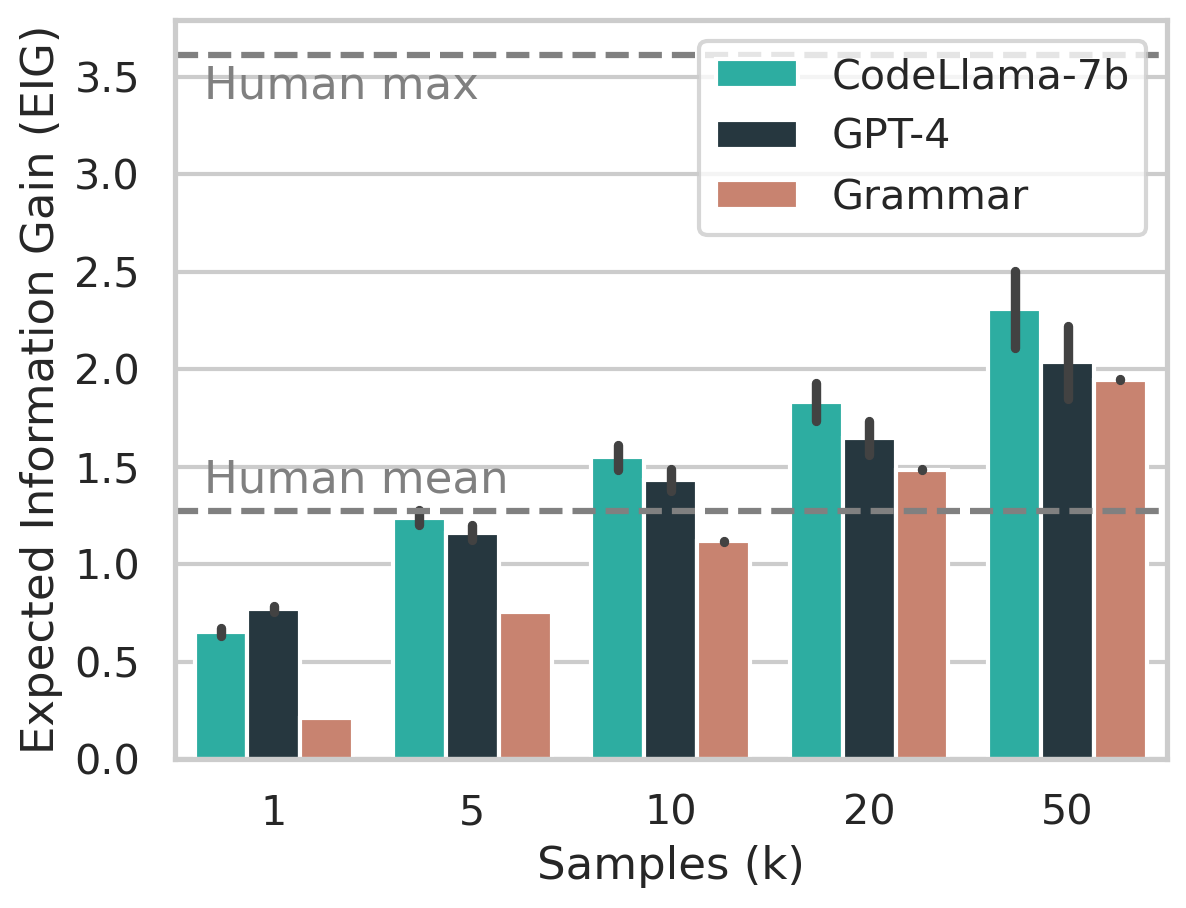

In [15]:
with sns.plotting_context("talk", font_scale=0.9):
    # sns.boxplot(data=df[df.model != "Human"], x="k", y="score", hue="model", palette=PALETTE, showfliers=False)

    data = df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"])]

    sns.barplot(
        data=data,
        x="k",
        y="score",
        hue="model",
        palette=PALETTE,
        errorbar="se",
    )

    # Add lines for human mean and max
    plt.axhline(human_mean, color="gray", linestyle="--")
    plt.axhline(human_max, color="gray", linestyle="--")

    # Add labels for human mean and max
    plt.text(-0.35, human_mean + 0.05, "Human mean", ha="left", va="bottom", color="gray")
    plt.text(-0.35, human_max - 0.05, "Human max", ha="left", va="top", color="gray")

    plt.xlabel("Samples (k)")
    plt.ylabel("Expected Information Gain (EIG)")

    # Rename models in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [
        "CodeLlama-7b",
        "GPT-4",
        "Grammar",
    ]
    plt.legend(handles, labels, loc="upper right")

    plt.savefig(os.path.join(FIGURES_DIR, "eig_vs_k.pdf"), bbox_inches="tight")

### Main models: pointplot

Text(0, 0.5, 'Expected Information Gain (EIG)')

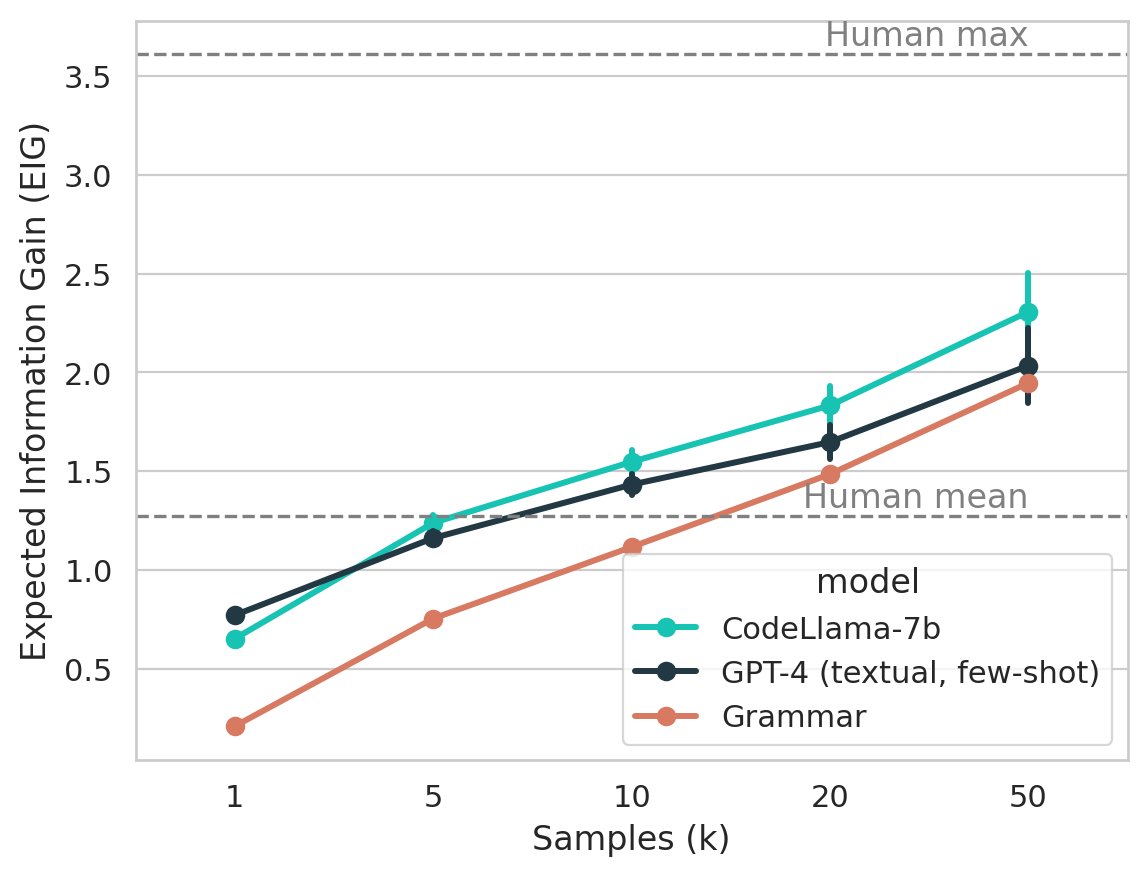

In [16]:
# plt.figure(figsize=(16, 8))

# sns.lineplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
# sns.pointplot(data=df[df.model != "Human"], x="k", y="score", hue="model", errorbar="se", palette=PALETTE)
sns.pointplot(
    data=df[df.model.isin(["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"])],
    x="k",
    y="score",
    hue="model",
    errorbar="se",
    palette=PALETTE,
)

# Add lines for human mean and max
plt.axhline(human_mean, color="gray", linestyle="--")
plt.axhline(human_max, color="gray", linestyle="--")

# Add labels for human mean and max
plt.text(4, human_mean + 0.01, "Human mean", ha="right", va="bottom", color="gray")
plt.text(4, human_max + 0.01, "Human max", ha="right", va="bottom", color="gray")


plt.xlabel("Samples (k)")
plt.ylabel("Expected Information Gain (EIG)")
# plt.xscale("log")

### EIG distributions at k=1

In [17]:
df_1 = df[df["k"] == 1]

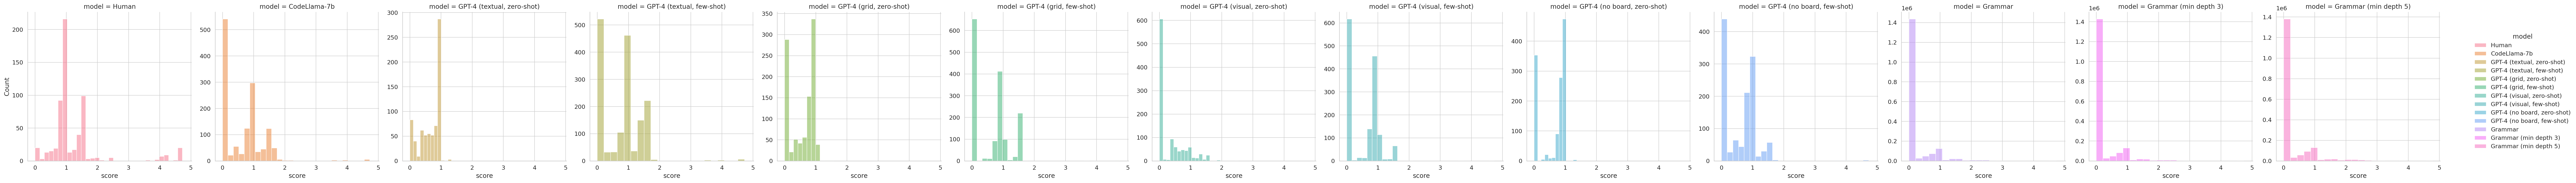

In [18]:
sns.displot(
    data=df_1,
    col="model",
    x="score",
    hue="model",
    common_norm=False,
    common_bins=False,
    facet_kws=dict(sharey=False)
)

### Grouped by trial

Text(0, 0.5, 'EIG')

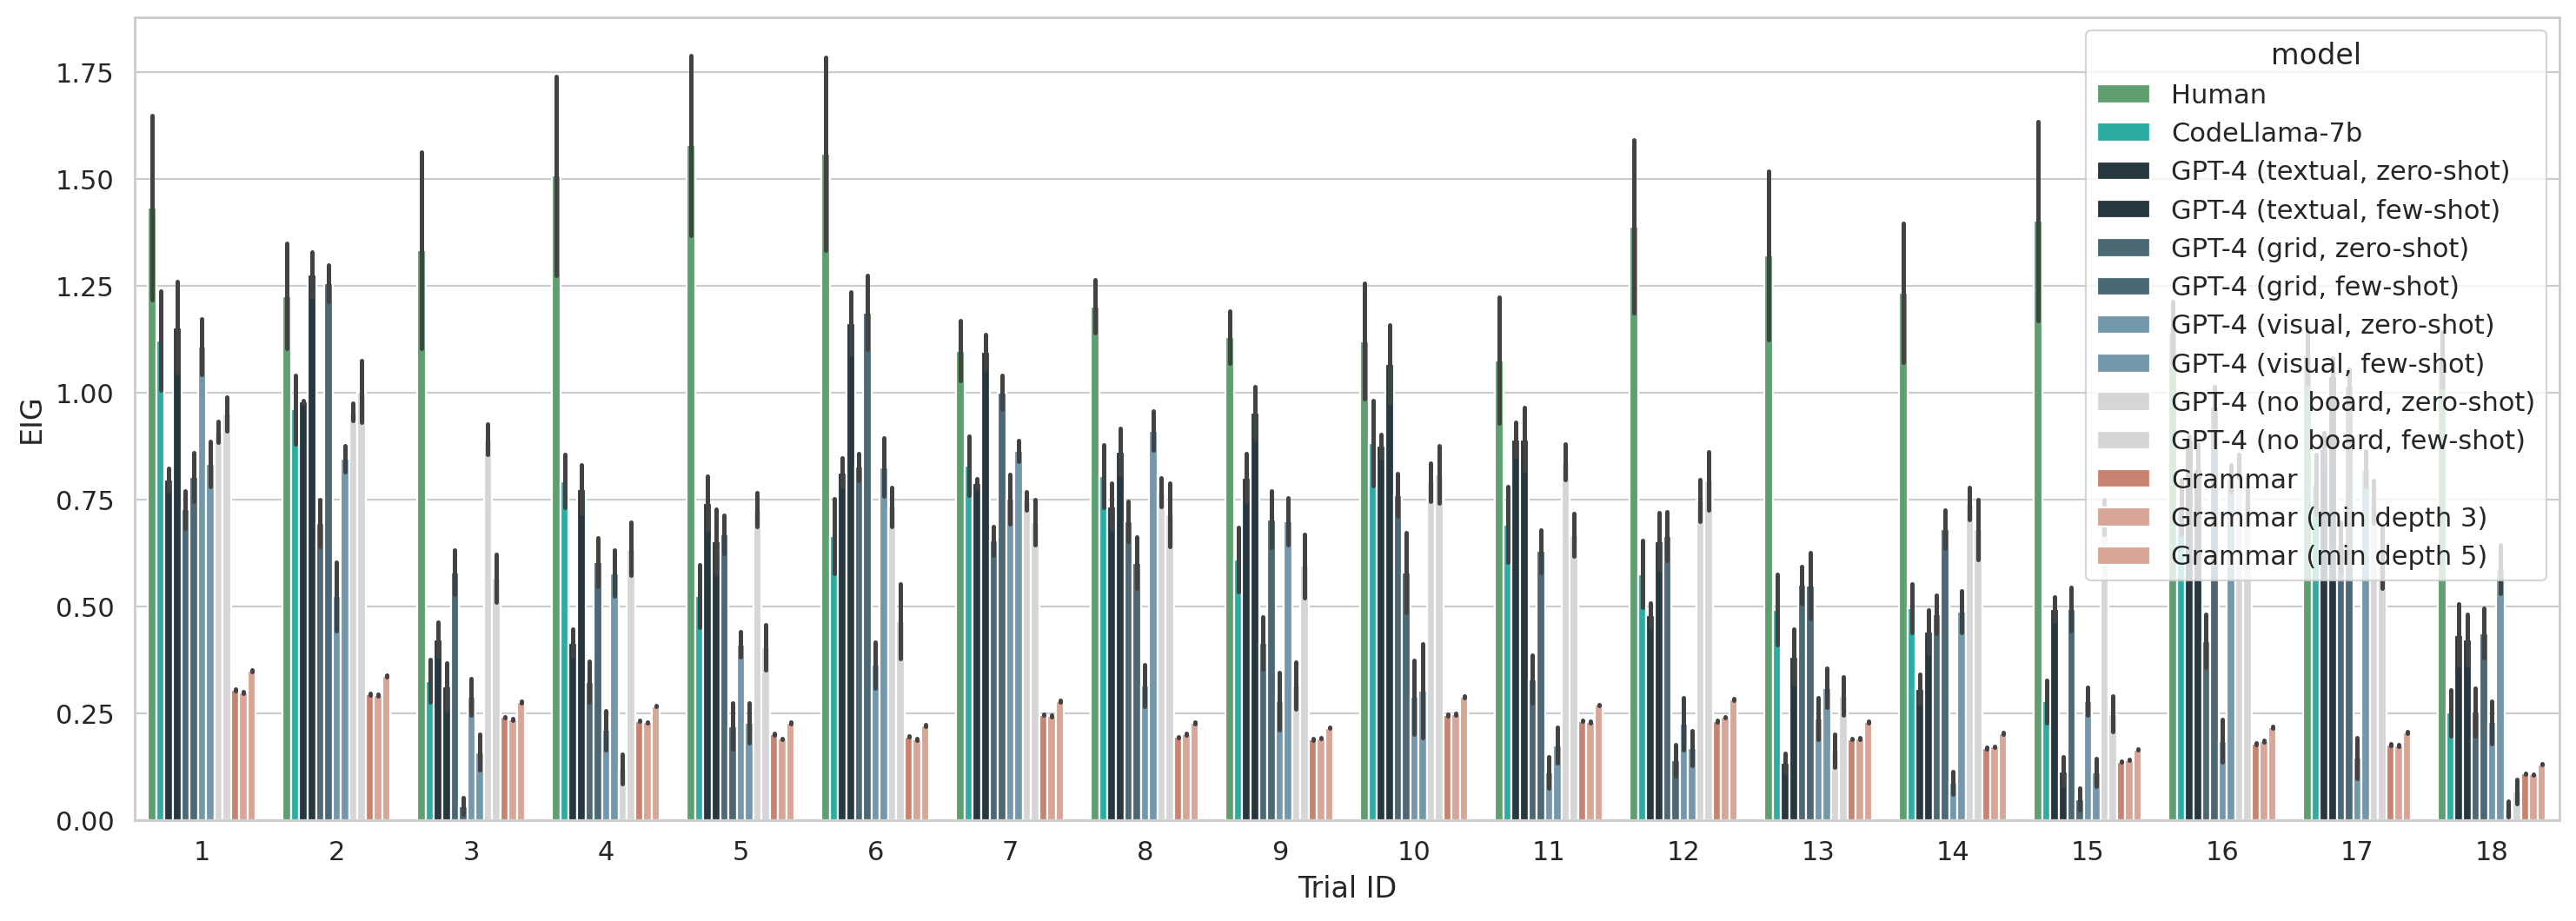

In [19]:
plt.figure(figsize=(18, 6))
sns.barplot(data=df_1, hue="model", x="trial_id", y="score", errorbar="se", palette=PALETTE)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

Text(0, 0.5, 'EIG')

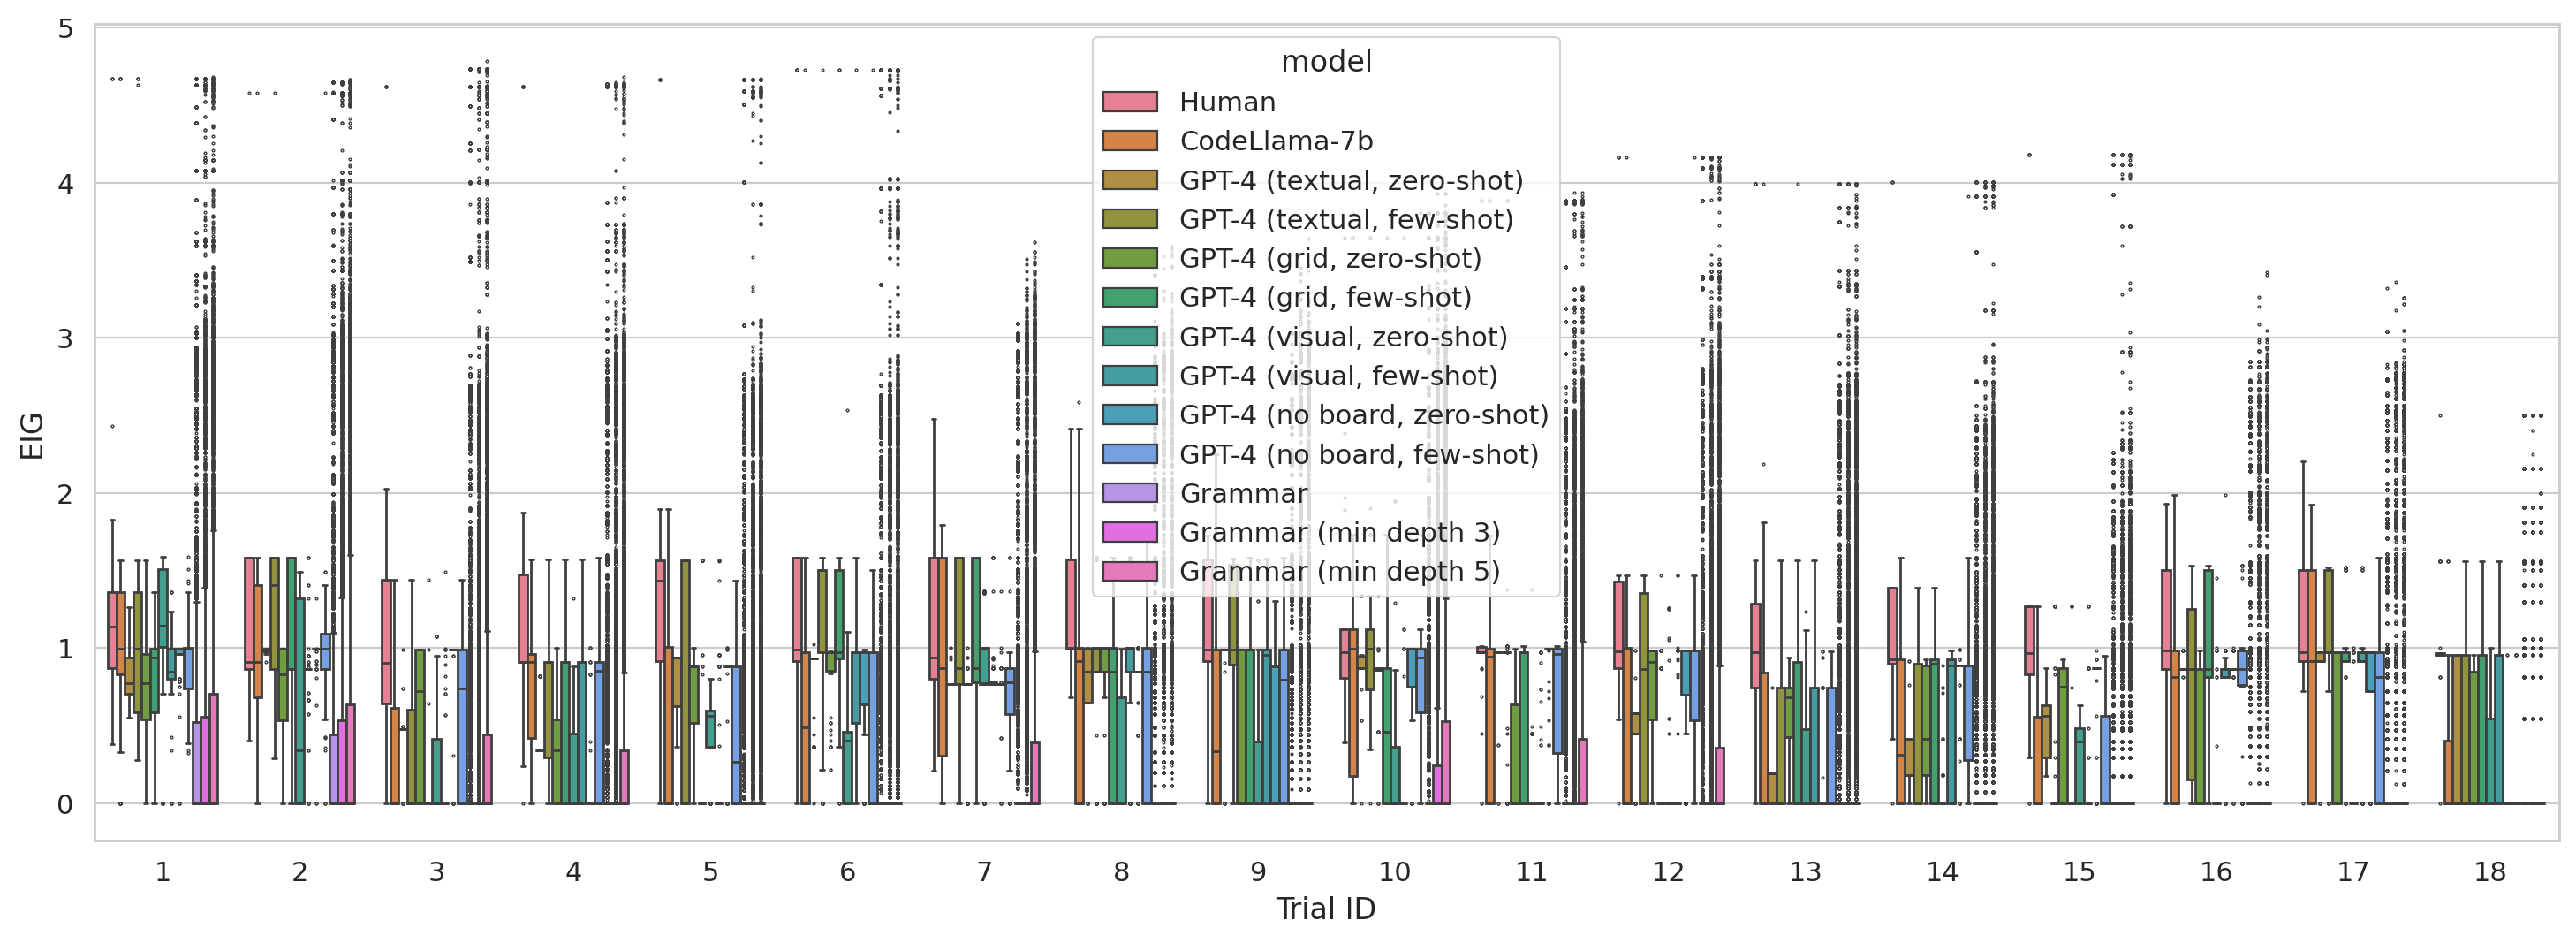

In [20]:
plt.figure(figsize=(18, 6))
# sns.boxplot(data=df, hue="model", x="trial_id", y="score", showfliers=False)
sns.boxplot(
    data=df_1,
    hue="model",
    x="trial_id",
    y="score",
    fliersize=1.0,
    flierprops={"marker": "."},
)
plt.xlabel("Trial ID")
plt.ylabel("EIG")

### EIG distributions for all k

Text(0, 0.5, 'EIG')

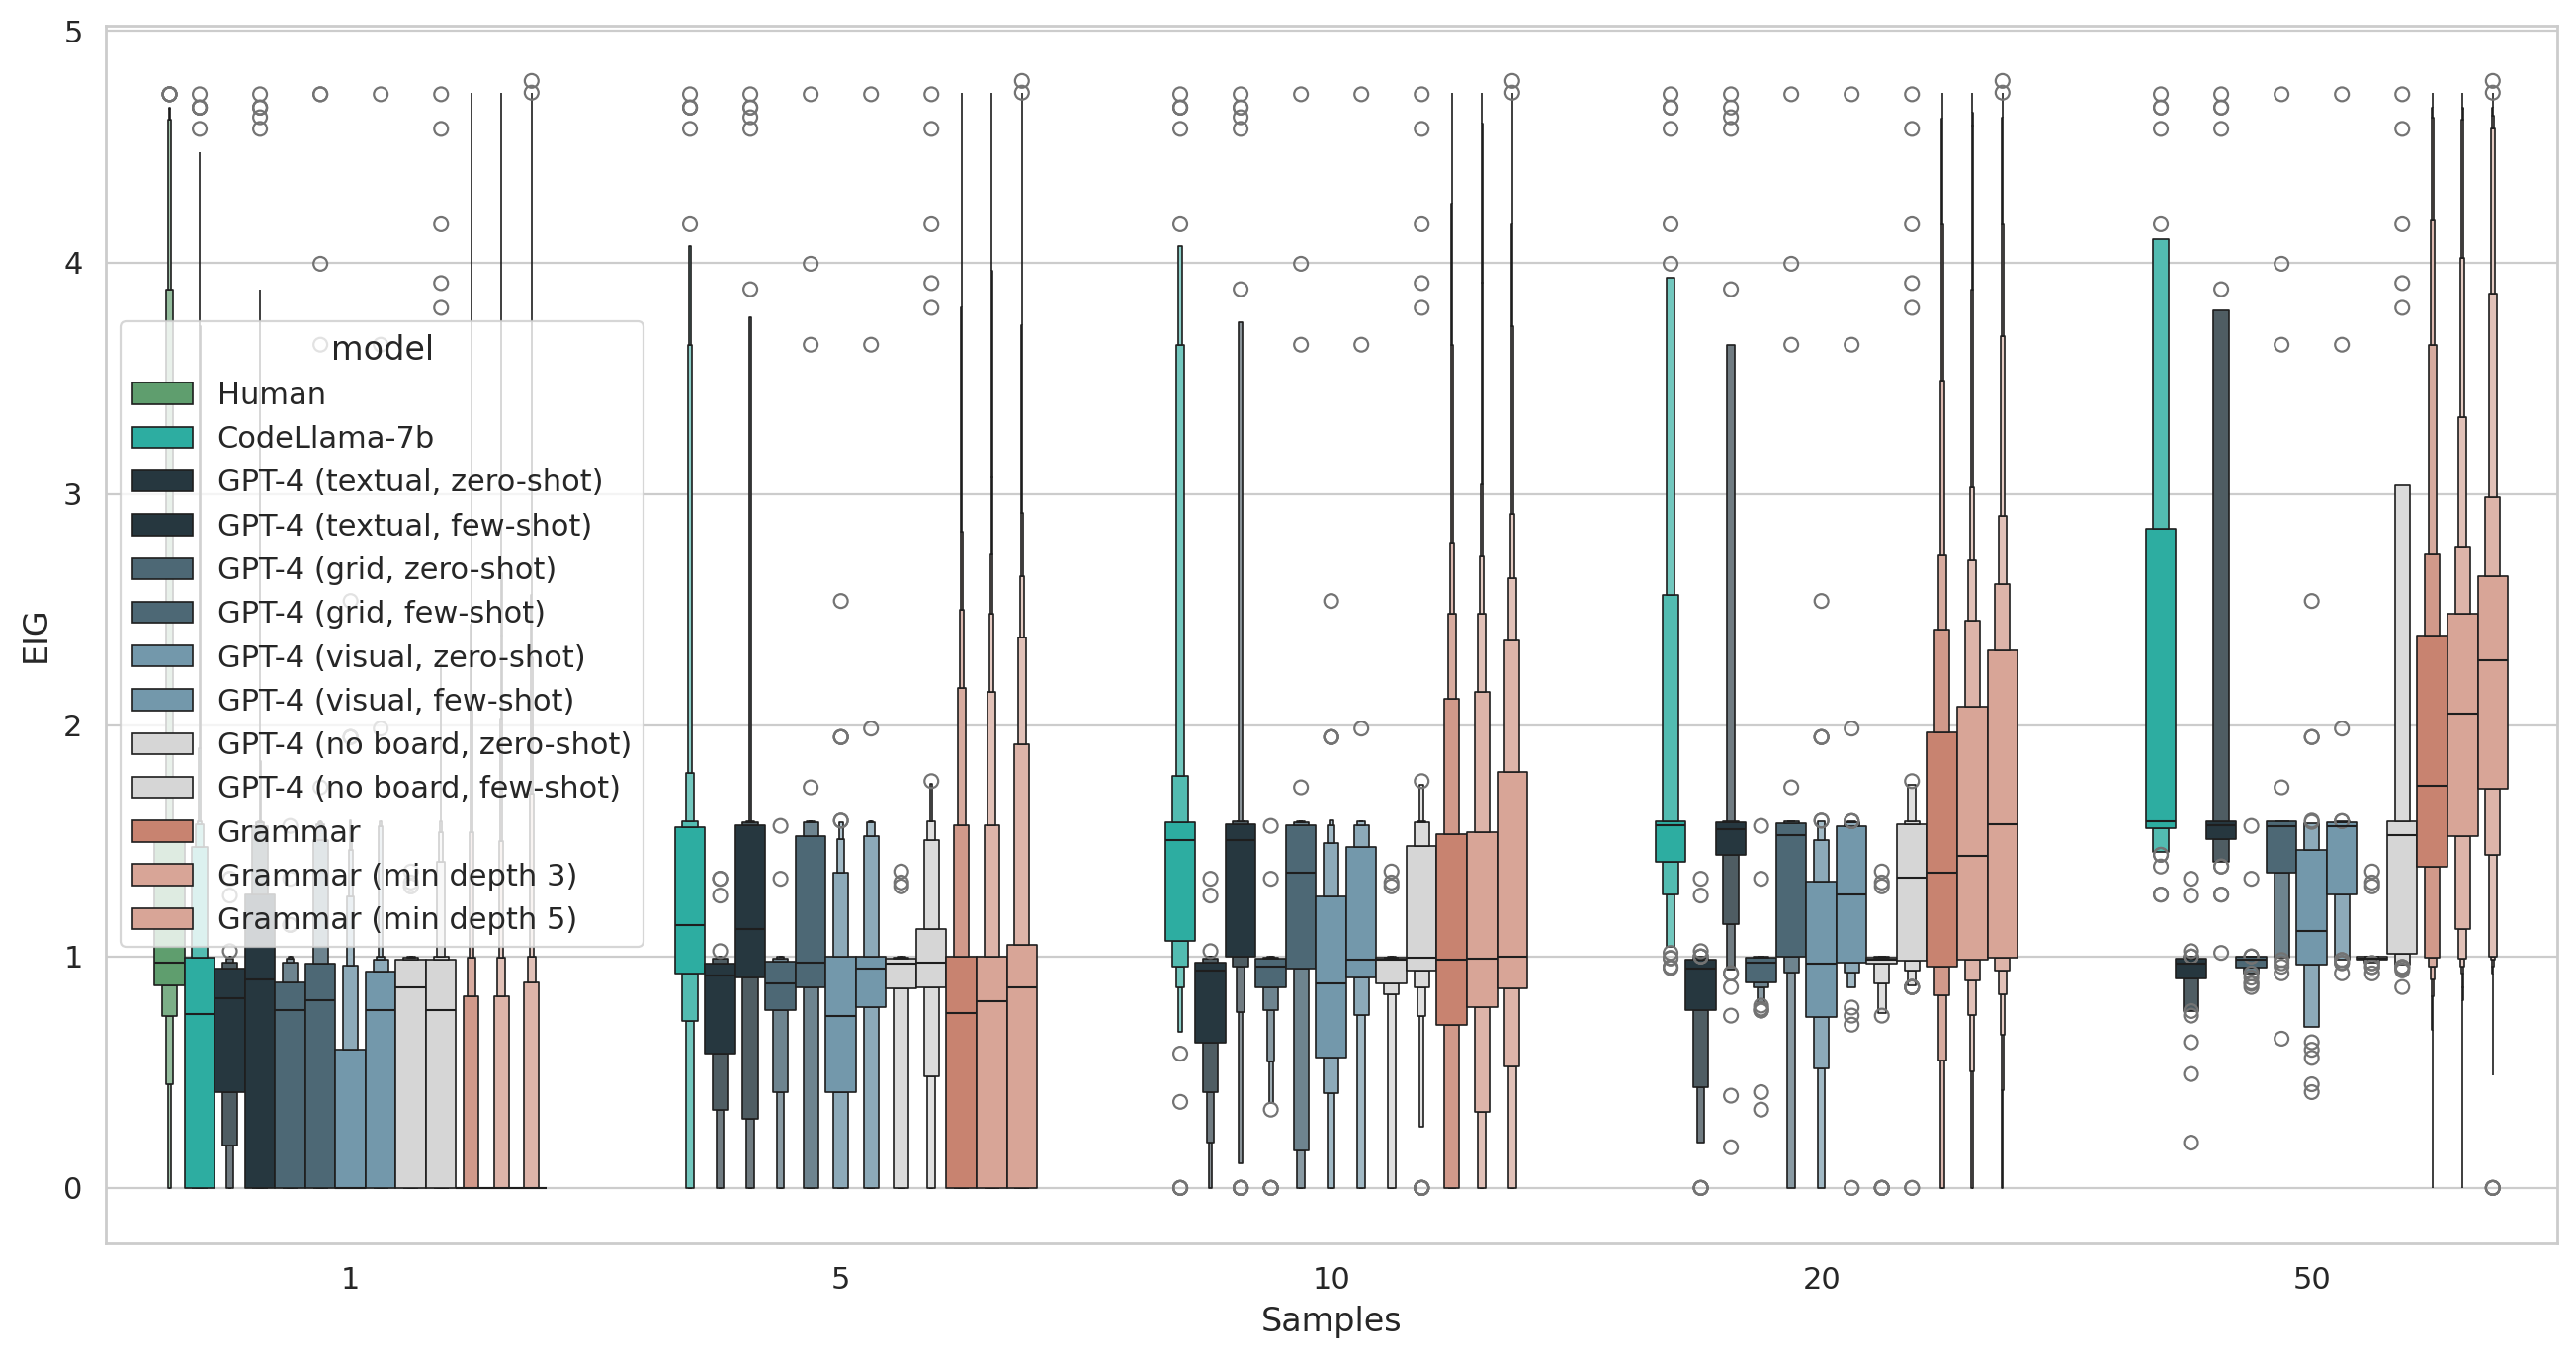

In [21]:
plt.figure(figsize=(16, 8))
# sns.pointplot(data=df, x="k", y="score", hue="model", errorbar="se")
sns.boxenplot(data=df, x="k", y="score", hue="model", palette=PALETTE)
plt.xlabel("Samples")
plt.ylabel("EIG")
# plt.xscale("log")

### EIG Percentile

In [22]:
data = []

human_scores = df_human.score.fillna(value=0).values

for (model, k, trial_id), df_group in df.groupby(["model", "k", "trial_id"]):
    scores = df_group.score.fillna(value=0).values
    for i in range(101):
        percentile_of_model = np.percentile(scores, i)
        percentile_of_human = percentileofscore(human_scores, percentile_of_model).item()
        data.append(
            {
                "model": model,
                "k": k,
                "trial_id": trial_id,
                "percentile": i,
                "score": percentile_of_model,
                "percentile_human": percentile_of_human,
            }
        )

df_eig_sum = pd.DataFrame(data)

In [23]:
df_eig_sum

model  k  trial_id  percentile     score  percentile_human
0       CodeLlama-7b  1         1           0  0.000000          1.735537
1       CodeLlama-7b  1         1           1  0.000000          1.735537
2       CodeLlama-7b  1         1           2  0.000000          1.735537
3       CodeLlama-7b  1         1           3  0.000000          1.735537
4       CodeLlama-7b  1         1           4  0.000000          1.735537
...              ... ..       ...         ...       ...               ...
110893         Human  1        18          96  1.561278         79.173554
110894         Human  1        18          97  1.561278         79.173554
110895         Human  1        18          98  1.842895         91.074380
110896         Human  1        18          99  2.171447         92.396694
110897         Human  1        18         100  2.500000         93.388430

[110898 rows x 6 columns]

Text(0, 0.5, 'EIG')

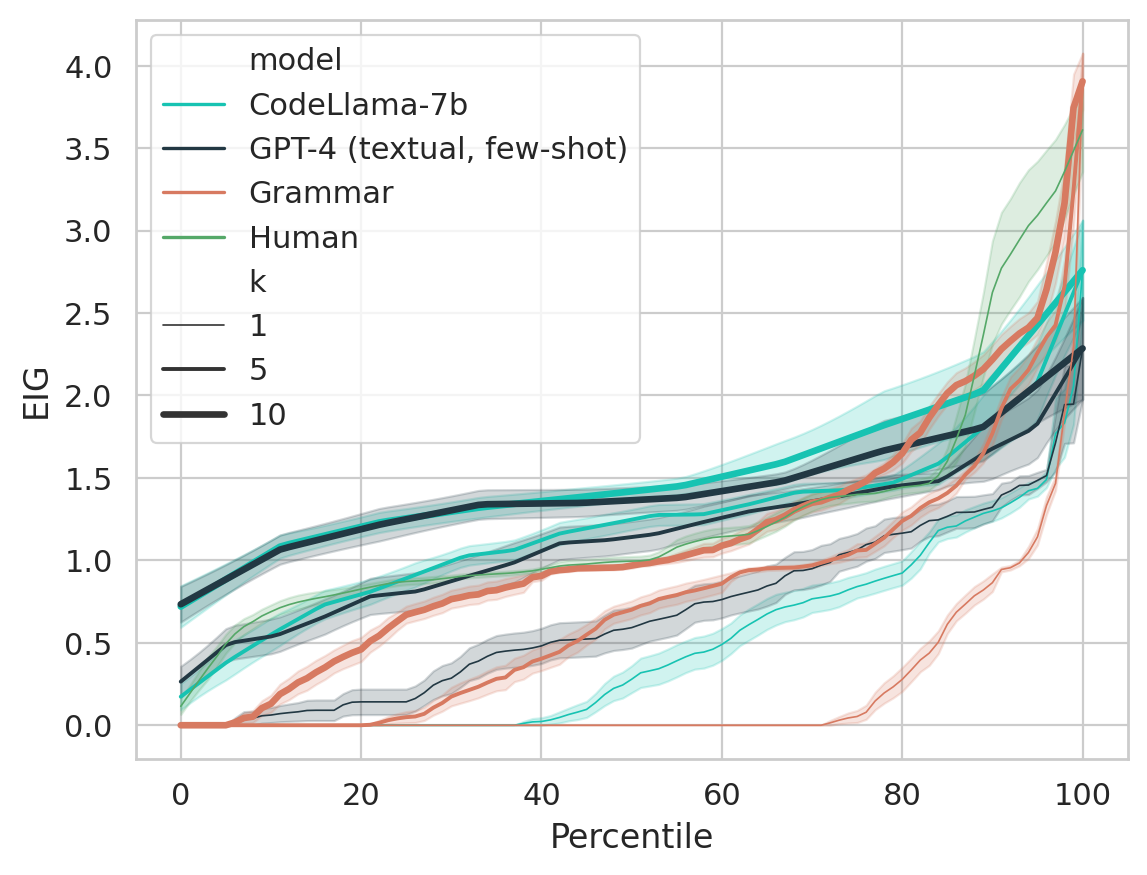

In [24]:
# plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

Text(1699.896111111111, 0.5, 'EIG')

<Figure size 1200x800 with 0 Axes>

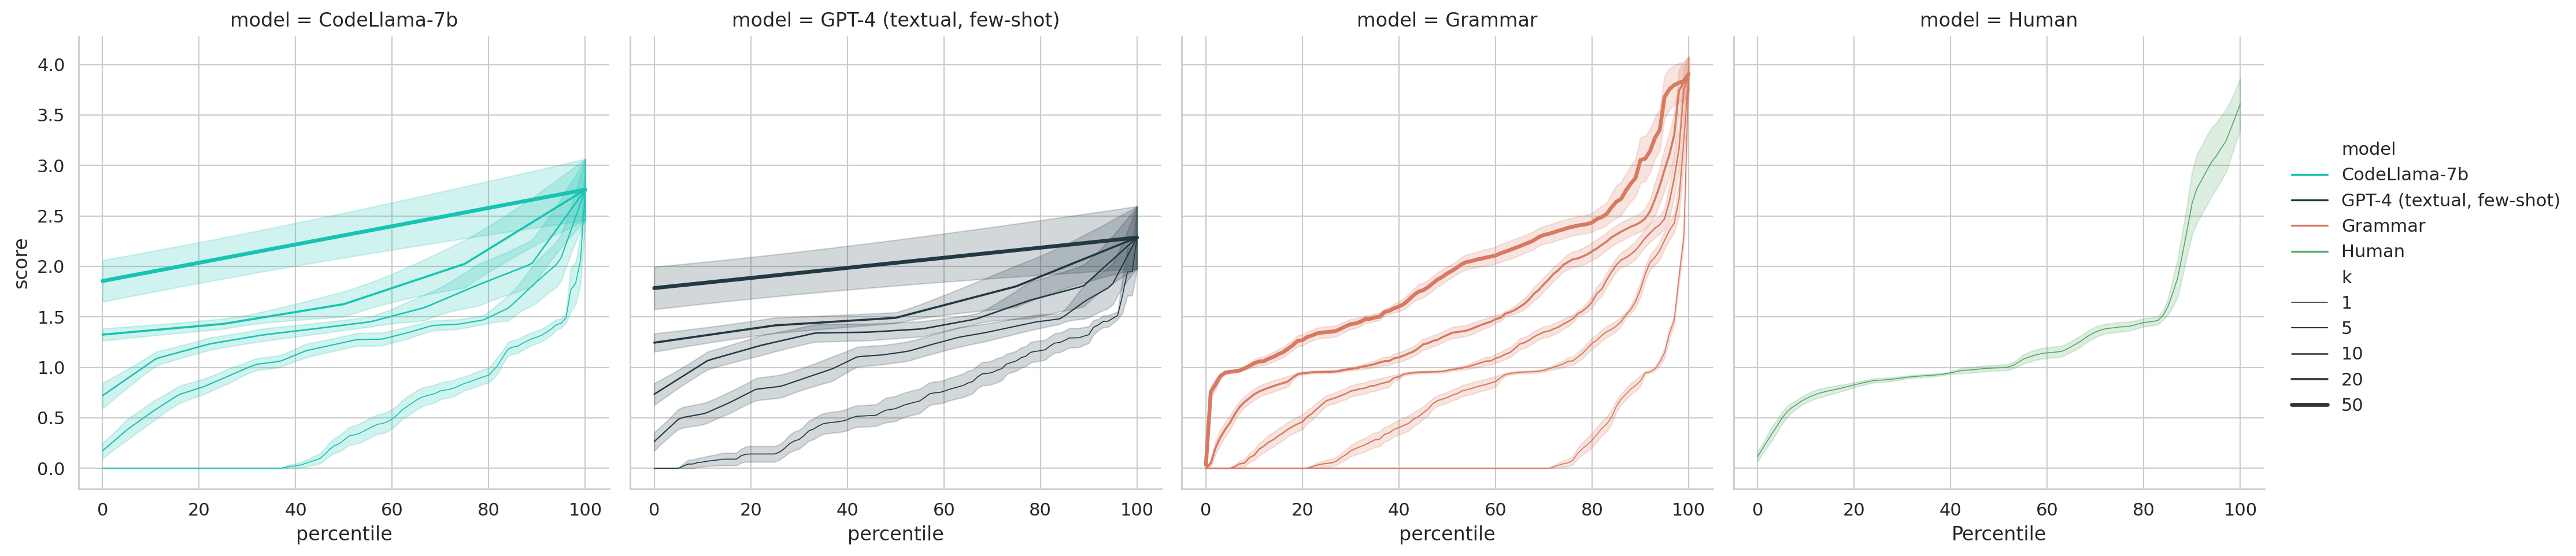

In [25]:
plt.figure(figsize=(12, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Human", "Grammar"]
sns.relplot(
    kind="line",
    col="model",
    data=df_eig_sum[(df_eig_sum["k"] <= 100) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="score",
    hue="model",
    size="k",
    errorbar="se",
    palette=PALETTE,
)
plt.xlabel("Percentile")
plt.ylabel("EIG")

### Q-Q Plot

Text(0, 0.5, 'Percentile of Human')

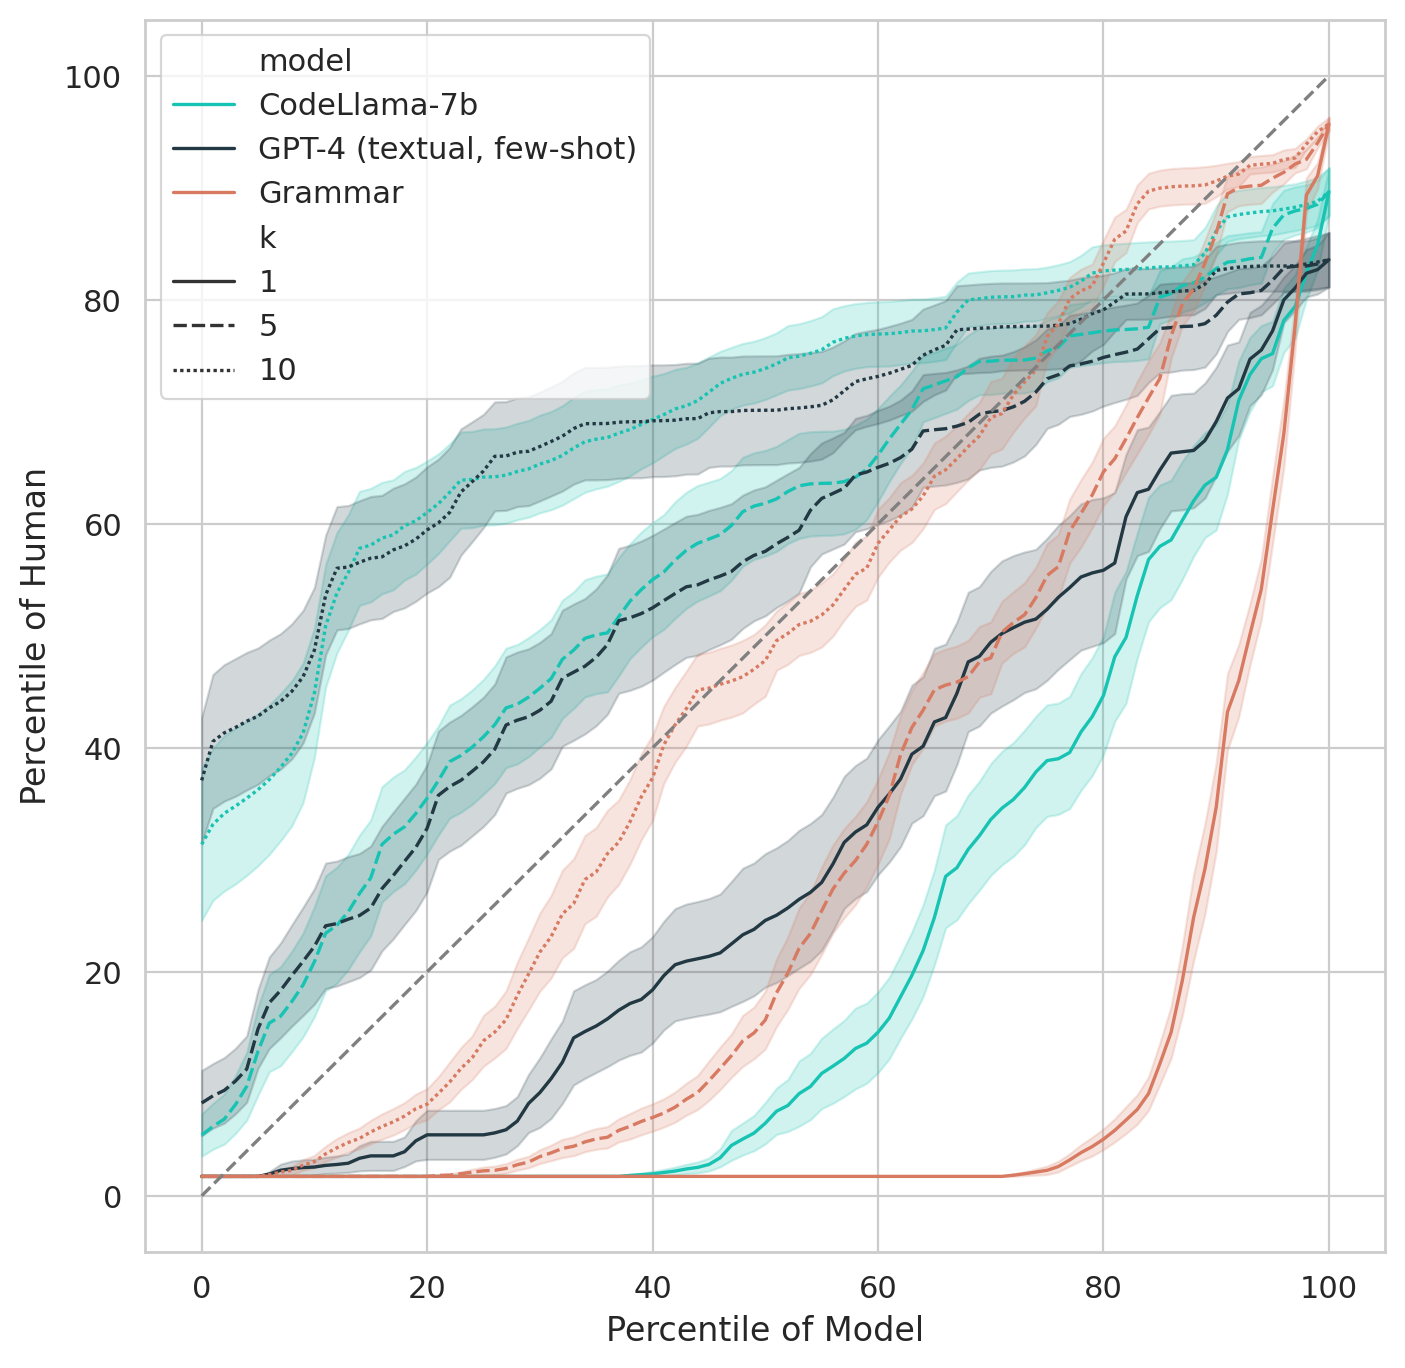

In [26]:
plt.figure(figsize=(8, 8))
models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"]
sns.lineplot(
    data=df_eig_sum[(df_eig_sum["k"] <= 10) & (df_eig_sum["model"].isin(models))],
    x="percentile",
    y="percentile_human",
    hue="model",
    style="k",
    errorbar="se",
    palette=PALETTE,
)

# Draw diagonal line
x = np.linspace(0, 100, 100)
plt.plot(x, x, color="gray", linestyle="--")

plt.xlabel("Percentile of Model")
plt.ylabel("Percentile of Human")

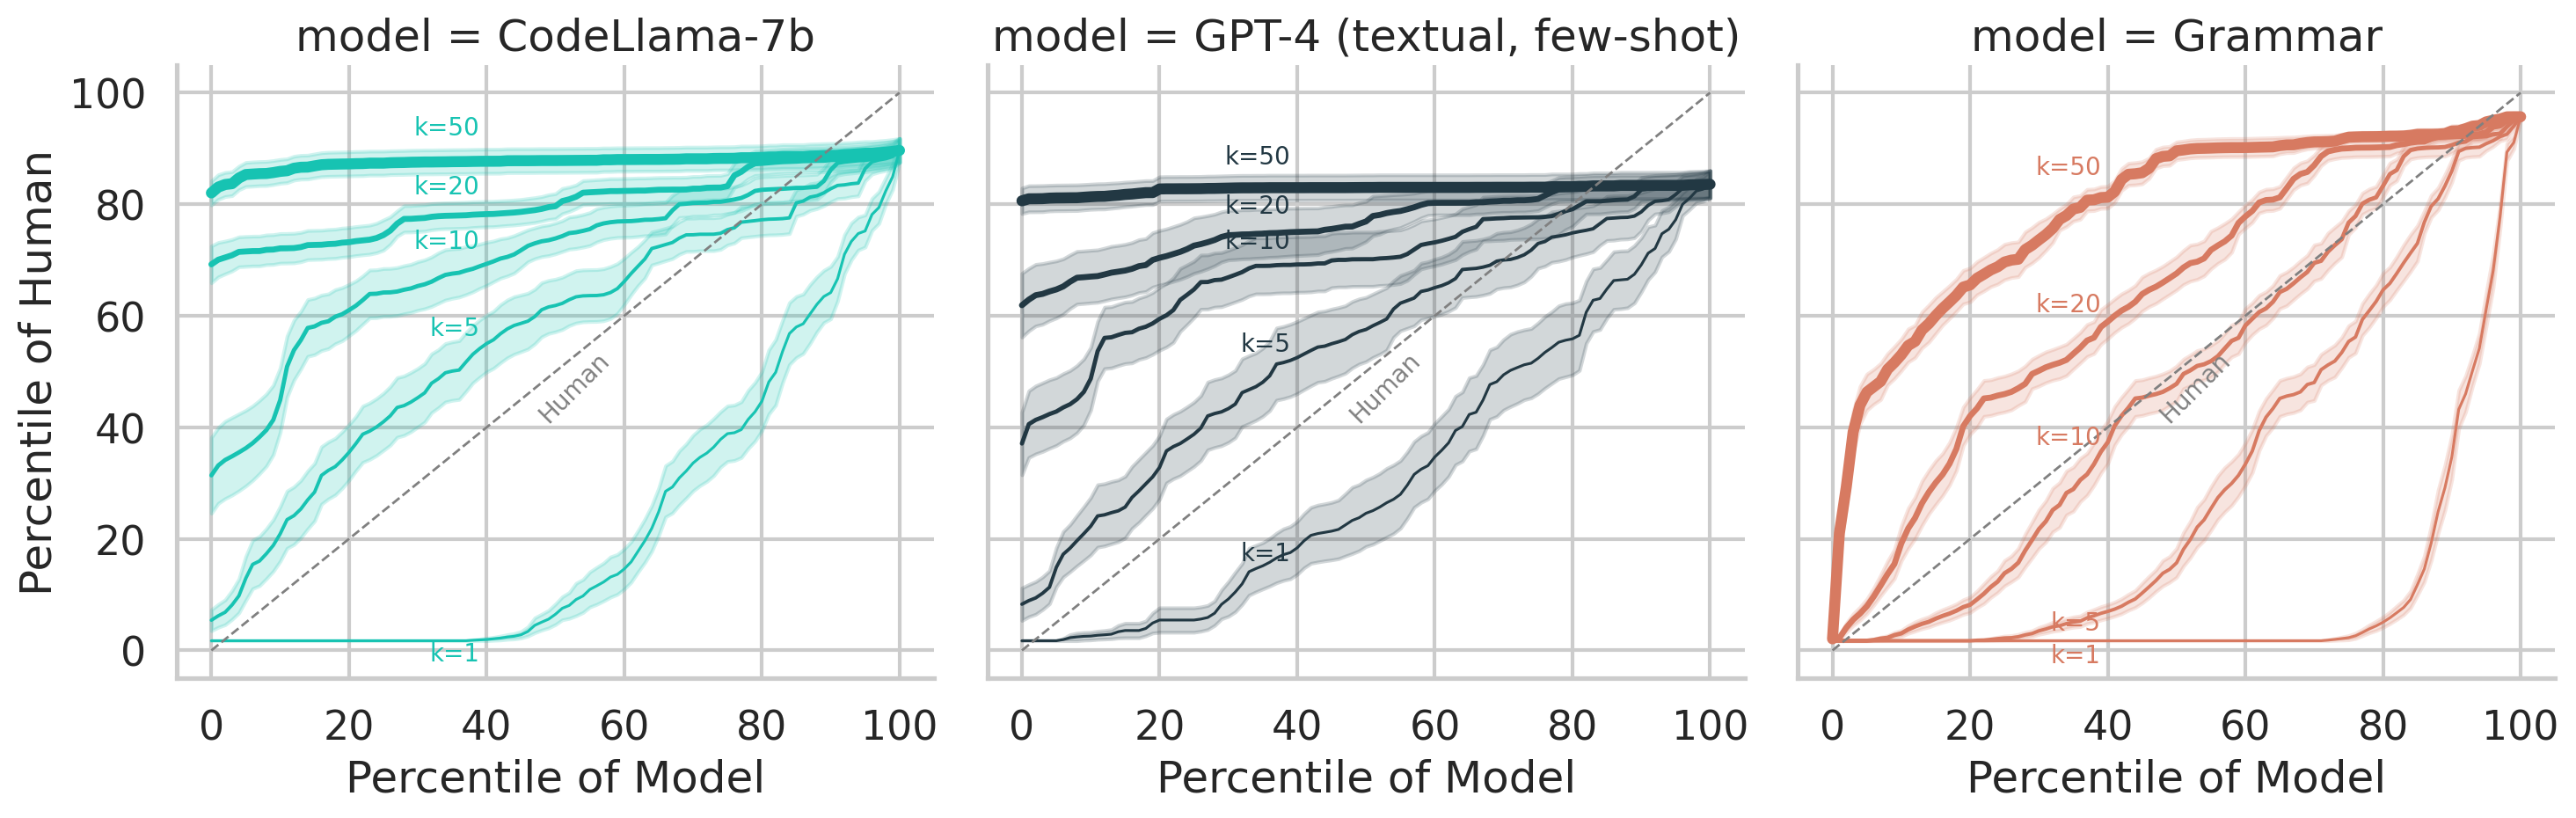

In [27]:
with sns.plotting_context("talk", font_scale=1.0):
    models = ["CodeLlama-7b", "GPT-4 (textual, few-shot)", "Grammar"]
    data = df_eig_sum[df_eig_sum["model"].isin(models)]

    sns.relplot(
        kind="line",
        data=data,
        col="model",
        x="percentile",
        y="percentile_human",
        hue="model",
        size="k",
        # style="k",
        errorbar="se",
        palette=PALETTE,
        legend=False,
    )


    for model, ax in zip(models, plt.gcf().axes):
        # Draw diagonal line on all plots
        x = np.linspace(0, 100, 100)
        ax.plot(x, x, color="gray", linestyle="--", linewidth=1.0)

        # Label the line diagonally
        ax.text(
            0.525,
            0.475,
            "Human",
            color="gray",
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            rotation=45,
        )

        ax.set_xlabel("Percentile of Model")
        ax.set_ylabel("Percentile of Human")

        # Add a label for each k
        for k in data.k.unique():

            # Compute value at Nth percentile
            N = 40
            y = data[(data["model"] == model) & (data["k"] == k) & (data["percentile"] == N)].percentile_human.mean()
            ax.text(
                x=(N / 100),
                y=(y / 100),
                s=f"k={k}",
                color=PALETTE[model],
                fontsize=10,
                horizontalalignment="right",
                verticalalignment="bottom",
                transform=ax.transAxes,
            )

plt.savefig(os.path.join(FIGURES_DIR, "percentile_plot.pdf"), bbox_inches="tight")

### Board format and few-shot

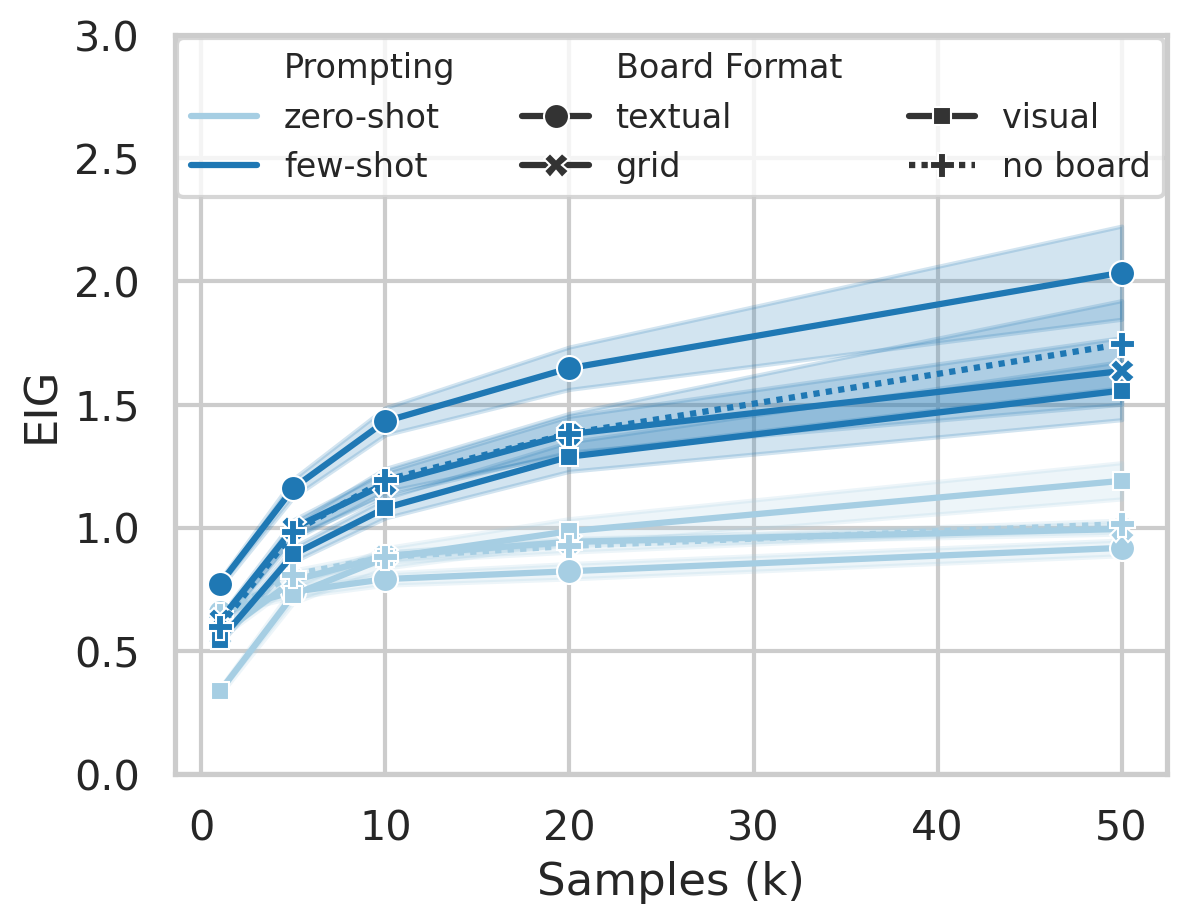

In [28]:
with sns.plotting_context("talk", font_scale=0.9):
    # plt.figure(figsize=(8, 6))

    COLOR_ZERO_SHOT = "#a6cee3"
    COLOR_FEW_SHOT = "#1f78b4"
    palette = sns.color_palette([
        COLOR_ZERO_SHOT,
        COLOR_FEW_SHOT,
    ])

    # textual / grid / visual palette
    # palette = sns.color_palette([COLOR_TEXTUAL, COLOR_GRID, COLOR_VISUAL, COLOR_NO_BOARD])

    sns.lineplot(
        data=df[df.model.str.contains("GPT-4")],
        x="k",
        y="score",
        style="Board Format",
        hue="Prompting",
        dashes=["", "", "", (1, 1)],
        markers=True,
        errorbar="se",
        palette=palette,
    )
    plt.xlabel("Samples (k)")
    plt.ylabel("EIG")
    # plt.xscale("log")

    # set y limit to 0
    plt.ylim(bottom=0, top=3.0)

    # Insert a pseudolabel to the legend at index 6
    handles, labels = plt.gca().get_legend_handles_labels()
    labels.insert(6, "")
    handles.insert(6, plt.Line2D([0], [0], linestyle=""))

    # # Split legend into two columns and move to top of figure
    # plt.legend(handles, labels, bbox_to_anchor=(0., 1.25), loc=2, borderaxespad=0.0, ncol=3, fontsize=12)

    # Split legend into two columns and move to top inside of figure
    plt.legend(handles, labels, loc="upper center", borderaxespad=0.1, ncol=3, fontsize=12)

    plt.savefig(os.path.join(FIGURES_DIR, "prompt_and_board_comparison.pdf"), bbox_inches="tight")

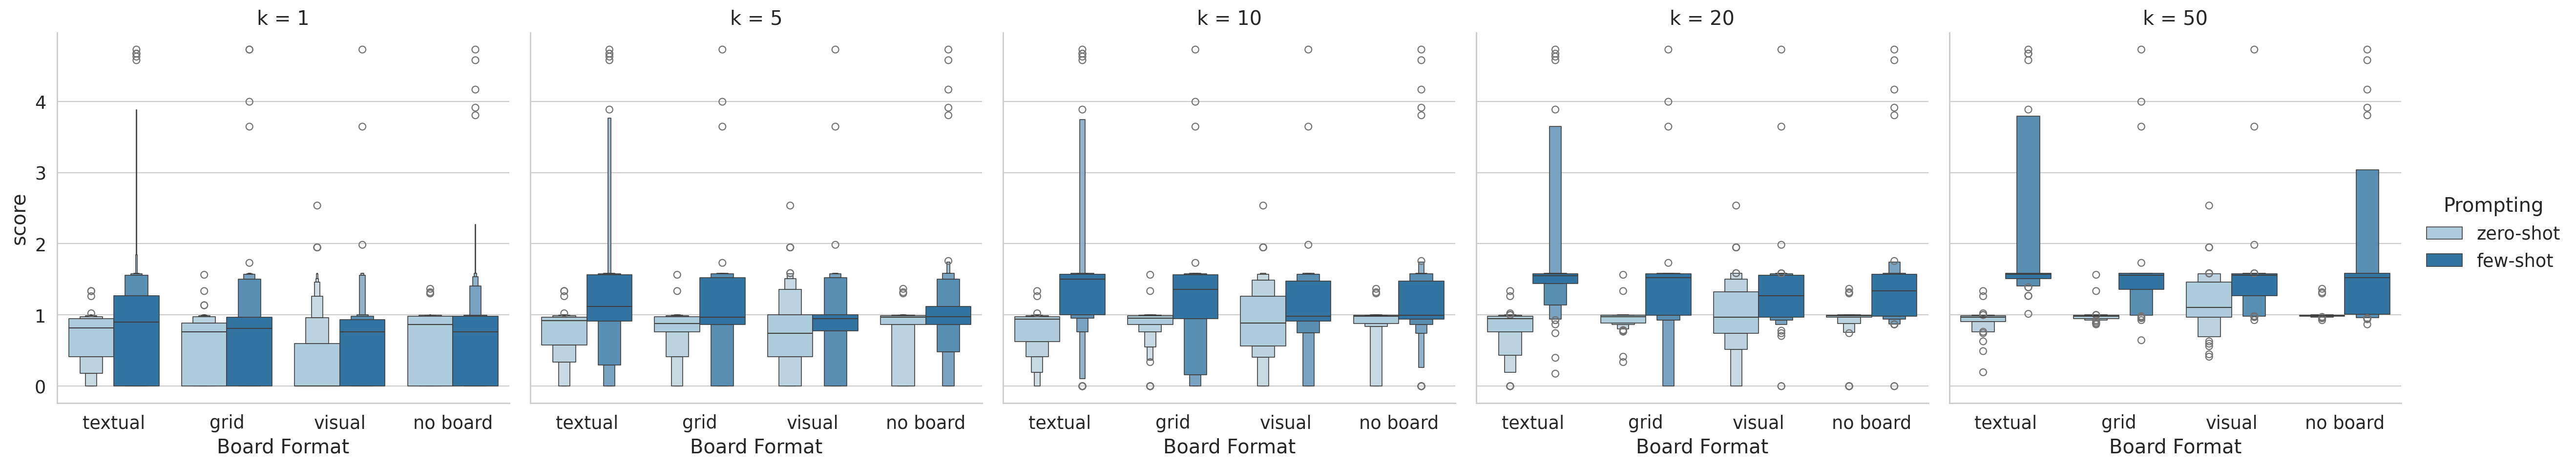

In [29]:
with sns.plotting_context("paper", font_scale=1.5):
    # plt.figure(figsize=(16, 8))

    # neutral 2-color binary palette
    palette = sns.color_palette("Paired", 2)

    sns.catplot(
        kind="boxen",
        data=df[df.model.str.contains("GPT-4")],
        x="Board Format",
        y="score",
        hue="Prompting",
        col="k",
        palette=palette,
    )
    # plt.xlabel("Samples")
    plt.ylabel("EIG")

# Grammar

(0.0, 16.0)

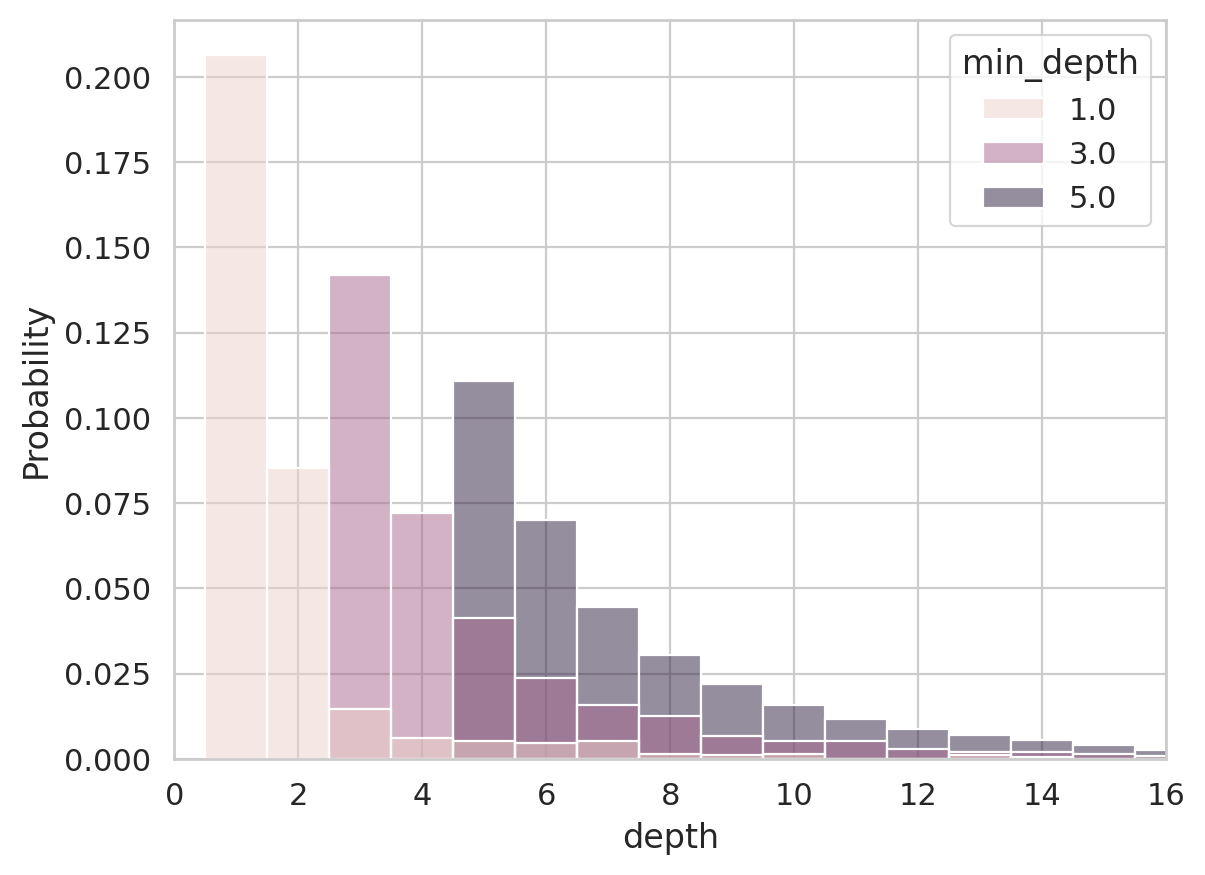

In [30]:
sns.histplot(
    data=df[df.model.str.contains("Grammar")],
    x="depth",
    hue="min_depth",
    stat="probability",
    discrete=True,
)

# set x limits to 0 and 16
plt.xlim(left=0, right=16)

Text(0, 0.5, 'EIG')

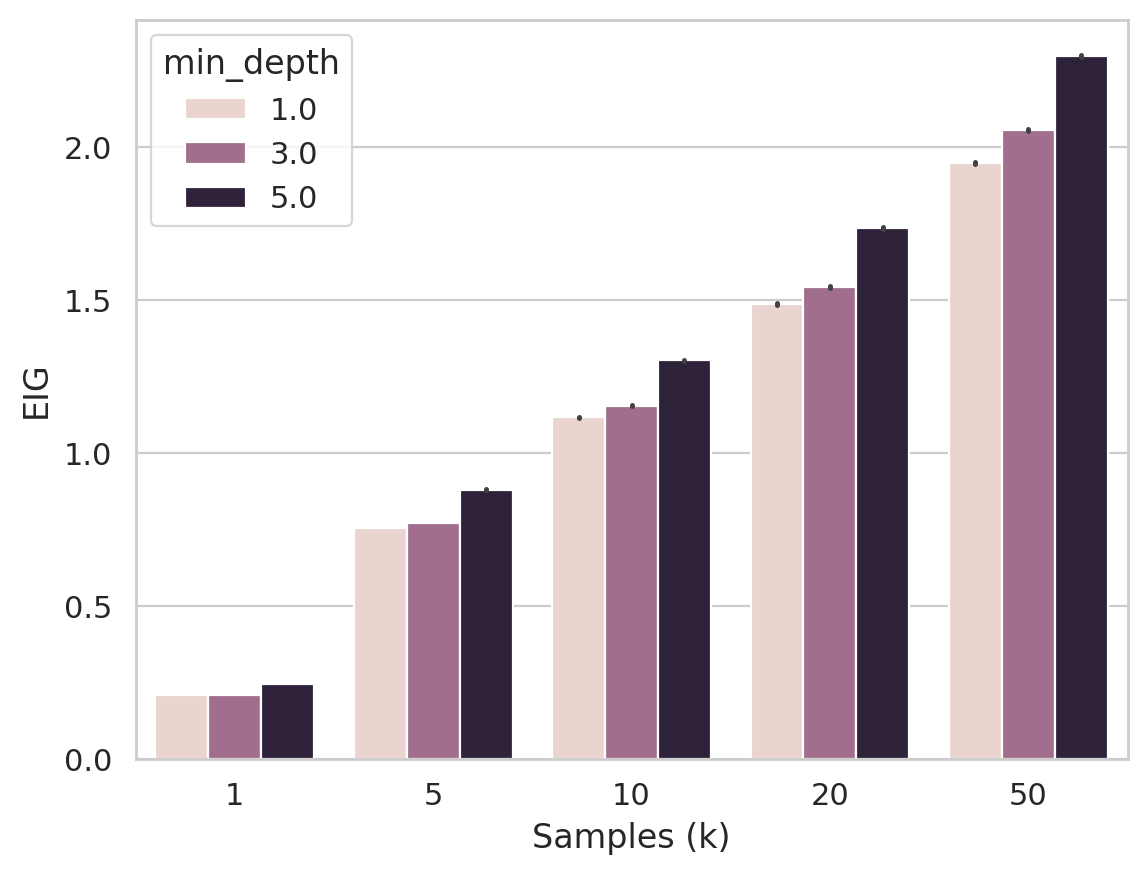

In [31]:
sns.barplot(
    data=df[df.model.str.contains("Grammar")],
    x="k",
    y="score",
    hue="min_depth",
    # palette="Paired",
    errorbar="se",
)

plt.xlabel("Samples (k)")
plt.ylabel("EIG")

## Analysis of superhuman questions

In [32]:
# Compute max human score for each trial id
df_max_human_score = df[df.model == "Human"].groupby("trial_id").score.max().reset_index().set_index("trial_id")
df_max_human_score

score
trial_id          
1         4.669496
2         4.577348
3         4.619552
4         4.620629
5         4.663079
6         4.726875
7         2.479554
8         2.413088
9         1.725572
10        3.644671
11        3.884286
12        4.164905
13        3.994077
14        4.002896
15        4.181366
16        1.927454
17        2.206239
18        2.500000

In [33]:
# Find "superhuman" questions: ones with score > max human score for each trial
data = []
for (trial_id, model), df_model in df.groupby(["trial_id", "model"]):
    if model == "Human":
        continue

    max_human_score = df_max_human_score.loc[trial_id].score.item()

    # Find questions with score > max human score
    df_superhuman = df_model[df_model.score > max_human_score]

    data.append(df_superhuman)

df_superhuman = pd.concat(data).reset_index(drop=True)
df_superhuman

trial_id question                                            program  \
0              1      NaN  ( < 7 ( - 6 ( + FALSE ( == ( color 3B ) ( colo...   
1              1      NaN  ( < 7 ( - 6 ( + FALSE ( == ( color 3B ) ( colo...   
2              1      NaN  ( < 7 ( - 6 ( + FALSE ( == ( color 3B ) ( colo...   
3              1      NaN  ( < 7 ( - 6 ( + FALSE ( == ( color 3B ) ( colo...   
4              1      NaN  ( < 7 ( - 6 ( + FALSE ( == ( color 3B ) ( colo...   
...          ...      ...                                                ...   
105361        17      NaN  ( color ( topleft ( coloredTiles ( color 5F ) ...   
105362        17      NaN  ( topleft ( union ( set AllTiles ) ( unique ( ...   
105363        17      NaN  ( or ( isSubset ( unique ( coloredTiles Water ...   
105364        17      NaN  ( not ( == ( == ( orient Purple ) ( orient Blu...   
105365        17      NaN  ( topleft ( setDifference ( coloredTiles Red )...   

           score                  model type  prompt_id   k Board Format  \
0       4.679277  Grammar (min depth 5)  NaN        NaN   1          NaN   
1       4.679277  Grammar (min depth 5)  NaN        NaN   5          NaN   
2       4.679277  Grammar (min depth 5)  NaN        NaN  10          NaN   
3       4.679277  Grammar (min depth 5)  NaN        NaN  20          NaN   
4       4.679277  Grammar (min depth 5)  NaN        NaN  50          NaN   
...          ...                    ...  ...        ...  ..          ...   
105361  2.209313  Grammar (min depth 5)  NaN        NaN  50          NaN   
105362  2.209313  Grammar (min depth 5)  NaN        NaN  50          NaN   
105363  2.209313  Grammar (min depth 5)  NaN        NaN  50          NaN   
105364  2.771405  Grammar (min depth 5)  NaN        NaN  50          NaN   
105365  2.209313  Grammar (min depth 5)  NaN        NaN  50          NaN   

       Prompting  depth  min_depth  max_depth  
0            NaN    6.0        5.0       16.0  
1            NaN    6.0        5.0       16.0  
2            NaN    6.0        5.0       16.0  
3            NaN    6.0        5.0       16.0  
4            NaN    6.0        5.0       16.0  
...          ...    ...        ...        ...  
105361       NaN    5.0        5.0       16.0  
105362       NaN    7.0        5.0       16.0  
105363       NaN   13.0        5.0       16.0  
105364       NaN    5.0        5.0       16.0  
105365       NaN    7.0        5.0       16.0  

[105366 rows x 13 columns]

In [34]:
df_superhuman_counts = df_superhuman.model.value_counts().astype(float)

# Divide Grammar by 1000
for model in df_superhuman_counts.index:
    if "Grammar" in str(model):
        df_superhuman_counts.loc[model] = df_superhuman_counts.loc[model] / 1000

# Convert to dataframe
df_superhuman_counts = df_superhuman_counts.reset_index()

df_superhuman_counts

model   count
0       Grammar (min depth 5)  45.021
1       Grammar (min depth 3)  30.885
2                     Grammar  29.428
3                CodeLlama-7b  22.000
4  GPT-4 (no board, few-shot)   5.000
5    GPT-4 (visual, few-shot)   5.000

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Grammar (min depth 5)'),
  Text(1, 0, 'Grammar (min depth 3)'),
  Text(2, 0, 'Grammar'),
  Text(3, 0, 'CodeLlama-7b'),
  Text(4, 0, 'GPT-4 (no board, few-shot)'),
  Text(5, 0, 'GPT-4 (visual, few-shot)')])

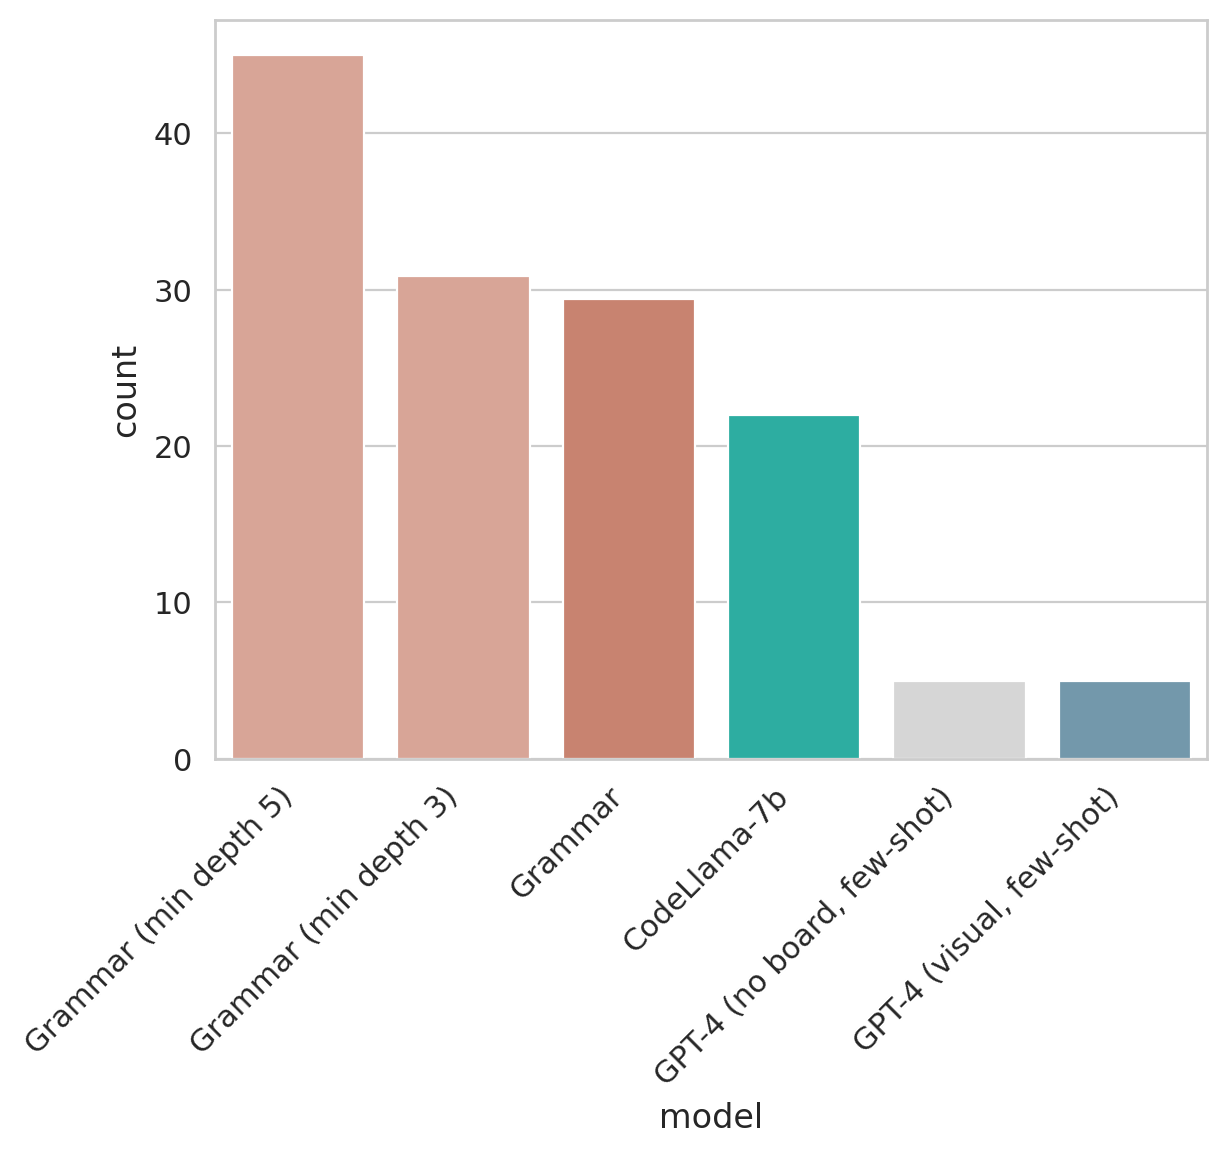

In [35]:
sns.barplot(data=df_superhuman_counts, x="model", y="count", hue="model", palette=PALETTE)

# Set axis labels 45 degrees
plt.xticks(rotation=45, ha="right")

In [36]:
df_superhuman[~df_superhuman.model.str.contains("Grammar")].drop_duplicates(subset=["trial_id", "model", "question", "program"])

trial_id                                           question  \
15959         8             What is the location of one blue tile?   
24939         9   Where is the bottom right tile of the blue ship?   
53537        10  Where is the bottom right part of the purple s...   
53542        10  At what location is the bottom right part of t...   
55780        16              What is the location of one red tile?   
55781        16  At what location is the top left part of the r...   
55787        16  At what location is the top left part of the r...   

                                   program     score  \
15959        (topleft (coloredTiles Blue))  2.584963   
24939    (bottomright (coloredTiles Blue))  2.248256   
53537  (bottomright (coloredTiles Purple))  3.803904   
53542  (bottomright (coloredTiles Purple))  3.803904   
55780         (topleft (coloredTiles Red))  1.985228   
55781         (topleft (coloredTiles Red))  1.985228   
55787         (topleft (coloredTiles Red))  1.985228   

                            model   type  prompt_id  k Board Format Prompting  \
15959                CodeLlama-7b  final        9.0  1          NaN       NaN   
24939                CodeLlama-7b  final       10.0  1          NaN       NaN   
53537                CodeLlama-7b  final       16.0  1          NaN       NaN   
53542  GPT-4 (no board, few-shot)    NaN        7.0  1     no board  few-shot   
55780                CodeLlama-7b  final        8.0  1          NaN       NaN   
55781                CodeLlama-7b  final        9.0  1          NaN       NaN   
55787    GPT-4 (visual, few-shot)    NaN       14.0  1       visual  few-shot   

       depth  min_depth  max_depth  
15959    NaN        NaN        NaN  
24939    NaN        NaN        NaN  
53537    NaN        NaN        NaN  
53542    NaN        NaN        NaN  
55780    NaN        NaN        NaN  
55781    NaN        NaN        NaN  
55787    NaN        NaN        NaN

In [37]:
df_sample = df_superhuman[df_superhuman.model.str.contains("Grammar")].drop_duplicates(
    subset=["trial_id", "model", "program"]
).query("trial_id == 10").sample(n=10, random_state=1)[["trial_id", "model", "program", "score"]]

In [38]:
df_sample.program.tolist()

['( - 1 ( + ( and ( == 5 ( + ( setSize ( intersection ( coloredTiles Water ) ( unique ( setDifference ( set AllTiles ) ( union ( coloredTiles Water ) ( union ( set AllTiles ) ( unique ( intersection ( unique ( set AllTiles ) ) ( coloredTiles Blue ) ) ) ) ) ) ) ) ) 6 ) ) ( > ( + 9 8 ) 6 ) ) ( < ( rowL 2F ) 2 ) ) )',
 '( not ( == V V ) )',
 '( == 0 ( setSize ( unique ( set AllTiles ) ) ) )',
 '( or ( == ( == V ( orient Blue ) ) TRUE ) ( not ( not ( == ( < 2 7 ) ( touch Red Blue ) ) ) ) )',
 '( setSize ( setDifference ( coloredTiles ( color 5E ) ) ( set AllTiles ) ) )',
 '( + ( > 8 9 ) ( or ( > 1 ( rowL 5F ) ) ( touch Purple Purple ) ) )',
 '( not ( not ( == ( size Purple ) ( + 3 8 ) ) ) )',
 '( not ( == FALSE FALSE ) )',
 '( == TRUE ( < ( setSize ( coloredTiles Water ) ) ( colL 3F ) ) )',
 '( + ( > 5 ( - ( + ( - 0 ( - ( setSize ( unique ( set AllTiles ) ) ) 0 ) ) 1 ) ( + ( and ( == ( size Purple ) ( colL 2F ) ) ( == 2 0 ) ) ( or FALSE TRUE ) ) ) ) ( not ( == ( touch Purple Purple ) ( and